---
**<h1><center> </center></h1>**

**<h1><center> Proyecto: Clasificación de cáncer de piel </center></h1>**

**<h2><center> Visión Por Computador - 2024-2</center></h2>**

<center><img src="https://upload.wikimedia.org/wikipedia/commons/c/c4/Escudo_unal_2016.png" width="100"></center>

---


<h1> Integrantes: </h1>

* Camilo Loaiza Fonnegra: cloaiza@unal.edu.co

* Luis Santiago Maya Restrepo: lmayar@unal.edu.co

* Jhon Sebastián Sepúlveda Nomesque: jsepulvedan@unal.edu.co

* Luis Alexander Torres Aguirre: luatorresag@unal.edu.co

* Andrés Felipe Zapata Osorio: anzapatao@unal.edu.co


## Descripción del Trabajo

## Importación de Librerias de trabajo

In [47]:
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown
import seaborn as sns
from scipy.stats import skew
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
from sklearn.decomposition import PCA
from pathlib import Path

In [48]:
# Definicion de variables globales

BASE_DIR = Path().resolve()
path_images = 'images' # Repositorio de imágenes
path_mask = 'masks' # Repositorio de máscaras
file_path_groundTruth = 'GroundTruth.csv' # Archivo con metadata


## Descripción del Dataset

En 2018 es liberada la primera versión del dataset [The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions](https://www.nature.com/articles/sdata2018161), publicado por Philipp Tschandl, Cliff Rosendahl y Harald Kittler, en este podemos encontrar 10015 imágenes dermatoscópicas captadas en el periodo de 20 años, estas se obtuvieron de dos fuentes diferentes, la primera del departamento de dermatología de la universidad de Vienna(Austria) y la investigación de cancer de piel liderada por el Profesor Cliff Rosendahl en Queensland(Australia). En el enlace anterior se puede evidenciar el proceso detallado realizado para el tratamiento de las imágenes y su categorización.

En este dataset encontraremos las 10015 imágenes dermatoscópicas en formato JPEG en alta calidad (300DPI; 15*10 cm), para un manejo adecuado el equipo que publica el dataset centro y adapto las imágenes a un tamaño de 800x600 px, el proceso automatizado para realizar la extracción y limpieza del mismo se puede encontrar en el repositorio github [HAM 10000 Dataset Tools](https://github.com/ptschandl/HAM10000_dataset).


Para nuestro proyecto final vamos a tomar el dataset del repositorio kaggel [Skin cancer: HAM10000](https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification/data), dentro de este encontraremos las 10015 imágenes y además un archivo CSV con la metadata del mismo (**GroundTruth.csv**), en este podremos observar el id de la imagen y además la categoría de la enfermedad la cual puede ser:

- MEL: Melanoma.
- NV: Melanocytic nevi
- BCC: Basal cell carcinoma.
- AKIEC: Bowen's disease / Actinic keratoses and intraepithelial carcinoma.
- BKL: Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)
- DF: Dermatofibroma
- VASC: Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage).

Realizando una validación inicial del archivo obtenemos un resumen de cuantas imágenes tenemos por clase.

In [58]:
# Lectura de archivo groundTruth con metadata
ground_truth = pd.read_csv(BASE_DIR/file_path_groundTruth)
# Mostrar las primeras filas para entender su estructura
ground_truth.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [56]:
# Se comprueba la no existencia de valores nulos
ground_truth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   10015 non-null  object 
 1   MEL     10015 non-null  float64
 2   NV      10015 non-null  float64
 3   BCC     10015 non-null  float64
 4   AKIEC   10015 non-null  float64
 5   BKL     10015 non-null  float64
 6   DF      10015 non-null  float64
 7   VASC    10015 non-null  float64
dtypes: float64(7), object(1)
memory usage: 626.1+ KB


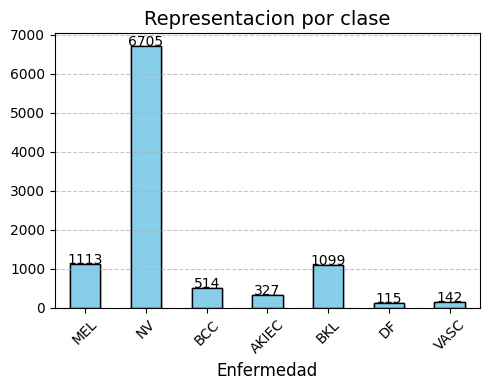

In [57]:
# Comprobar la representacion de enfermedades dentro del dataset.
suma_columnas = ground_truth.sum(numeric_only=True)
plt.figure(figsize=(5, 4))
suma_columnas.plot(kind='bar', color='skyblue', edgecolor='black')
ax = suma_columnas.plot(kind='bar', color='skyblue', edgecolor='black')

# Agregar los valores encima de las barras
for i, valor in enumerate(suma_columnas):
    ax.text(i, valor + 0.2, f'{int(valor)}', ha='center', fontsize=10, color="black")

# Personalizar el gráfico
plt.title("Representacion por clase", fontsize=14)
plt.xlabel("Enfermedad", fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfico
plt.tight_layout()
plt.show()

## Visualización de las Imágenes

## Análisis de Ruido en las Imágenes

**El ruido** se refiere a variaciones no deseadas o aleatorias en los valores de los píxeles que oscurecen o degradan la calidad de la imagen.
Puede surgir durante:
* La adquisición de la imagen (por ejemplo, imperfecciones en los sensores de las cámaras).
* Errores de compresión o transmisión.
* Condiciones ambientales (como iluminación o sombras).

**Tipos comunes de ruido:**

1. **Ruido Gaussiano**: Variaciones aleatorias que siguen una distribución Gaussiana, a menudo debido a limitaciones de los sensores.
2. **Ruido Sal y Pimienta**: Píxeles blancos y negros dispersos de manera aleatoria por la imagen.
3. **Ruido de Poisson**: Relacionado con la emisión de fotones durante la captura de la imagen (frecuente en imágenes médicas).
4. **Ruido de moteado (Speckle Noise)**: Común en imágenes capturadas con luz coherente (como láseres).

El siguiente es un ejemplo de una imagen con ruido por bellosidad presente:

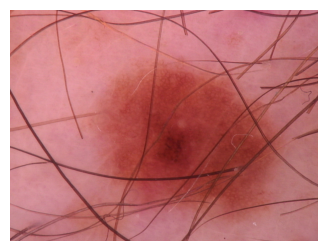

In [52]:
# Leemos una imagen ejemplo con ruido por bellos
img = cv2.imread(BASE_DIR/path_images/'ISIC_0024368.jpg', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Mostramos la imagen
plt.figure(figsize=(4, 3))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# Otras con el mismo tipo de ruido
# ISIC_0024374.jpg
# ISIC_0024382.jpg
# ISIC_0024384.jpg
# ISIC_0024397.jpg

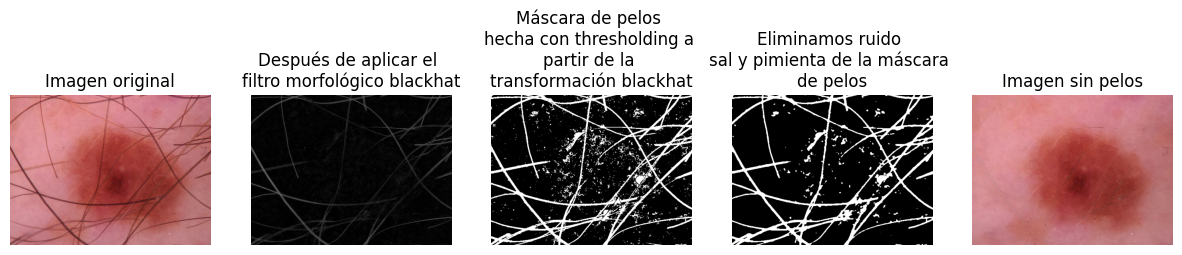

In [53]:
# Tratamiento de imagen individual

image_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises

# Aplicar un filtro morfológico para eliminar pelos
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))  # Tamaño del kernel
blackhat = cv2.morphologyEx(image_gray, cv2.MORPH_BLACKHAT, kernel)

# Crear una máscara de pelos
_, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

filtered_image_hair_mask = cv2.medianBlur(hair_mask, 5)


# Suavizar la imagen para rellenar las áreas afectadas
inpainted_image = cv2.inpaint(img_rgb, filtered_image_hair_mask, inpaintRadius=16, flags=cv2.INPAINT_TELEA)
inpainted_image_rgb = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)

# Mostrar los resultados
plt.figure(figsize=(15, 10))

plt.subplot(1, 5, 1)
plt.imshow(img_rgb)
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(cv2.cvtColor(blackhat, cv2.COLOR_BGR2RGB))
plt.title("Después de aplicar el \nfiltro morfológico blackhat")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(hair_mask, cmap="gray")
plt.title("Máscara de pelos \nhecha con thresholding a \npartir de la \ntransformación blackhat")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(filtered_image_hair_mask, cmap="gray")
plt.title("Eliminamos ruido \nsal y pimienta de la máscara \nde pelos")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(inpainted_image)
plt.title("Imagen sin pelos")
plt.axis("off")

plt.show()

#Próximos pasos: 

# -> msotrar histograma para filtro morfológico
# -> Mostrar paso de medianBlur 
# -> Mostrar varias imagenes antes y después
# -> Crear función para eliminar pelos
# -> Explicar bien cada paso en el notebook
# -> ¿Será posible hacerlo con filtro Canny?
    

## Análisis de Modelo de Color

El proyecto HAM10000 proporciona un conjunto de datos de 10,015 imágenes de lesiones cutáneas pigmentadas, clasificadas en siete categorías diagnósticas comunes. Estas imágenes son ideales para estudiar características visuales como el color y la textura para la detección de cáncer de piel.

A continuación, se describen los posibles análisis de modelo de color que realizaremos en este proyecto:

---

1. **Conversión de Espacios de Color**
Transformar las imágenes desde el espacio RGB a otros espacios como:
- **HSV (Hue, Saturation, Value):** Permite analizar los tonos y saturación de los colores.
- **CIELAB:** Proporciona una separación más perceptual de los colores.

Esto puede resaltar características específicas de las lesiones que no son evidentes en RGB.

---

2. **Análisis de Distribución de Color**
Calcular histogramas de color para cada canal (R, G, B) o los canales equivalentes en otros espacios de color (H, S, V). Esto permite:
- Identificar patrones cromáticos predominantes.
- Detectar anomalías o irregularidades en las distribuciones de color.

---

3. **Extracción de Características Cromáticas**
Extraer características estadísticas del color en las regiones segmentadas:
- Media y desviación estándar de cada canal.
- Momentos de color (primero, segundo y tercero).
- Valores máximos y mínimos de cada canal.

Estas métricas pueden ser usadas como entradas para modelos de clasificación.

---

4. **Análisis Combinado de Textura y Color**
Integrar características de textura (como LBP o GLCM) con características cromáticas:
- Mejora la representación de las lesiones.
- Incrementa la precisión en la detección de patrones malignos.

---

**Consideraciones**
1. **Preprocesamiento de Datos:**
   - Normalización de imágenes.
   - Eliminación de ruido en las imágenes.

2. **Validación Cruzada:**
   - Utilizar validación cruzada para evaluar los modelos de clasificación.

3. **Visualización de Resultados:**
   - Representar gráficamente los histogramas, las características extraídas y los resultados del modelo.

---


**Diccionario de variables**

| Variable                | Definición                                                                 |
|-------------------------|---------------------------------------------------------------------------|
| **image**              | Identificador único de cada imagen.                                       |
| **MEL**                | Indicador binario para melanoma (1 si la lesión es melanoma, 0 de lo contrario). |
| **NV**                 | Indicador binario para nevus (1 si la lesión es nevus, 0 de lo contrario). |
| **BCC**                | Indicador binario para carcinoma basocelular (1 si la lesión es BCC, 0 de lo contrario). |
| **AKIEC**              | Indicador binario para queratosis actínica o carcinoma (1 si es AKIEC, 0 de lo contrario). |
| **BKL**                | Indicador binario para queratosis benigna (1 si es BKL, 0 de lo contrario). |
| **DF**                 | Indicador binario para dermatofibroma (1 si es DF, 0 de lo contrario).    |
| **VASC**               | Indicador binario para lesiones vasculares (1 si es VASC, 0 de lo contrario). |
| **hsv_channel_0_mean** | Media del canal Hue (tono) en el espacio de color HSV.                    |
| **hsv_channel_0_std**  | Desviación estándar del canal Hue en el espacio de color HSV.             |
| **hsv_channel_0_peak** | Pico del histograma del canal Hue en el espacio de color HSV.             |
| **hsv_channel_1_mean** | Media del canal Saturation (saturación) en el espacio de color HSV.       |
| **hsv_channel_1_std**  | Desviación estándar del canal Saturation en el espacio de color HSV.      |
| **hsv_channel_1_peak** | Pico del histograma del canal Saturation en el espacio de color HSV.      |
| **hsv_channel_2_mean** | Media del canal Value (brillo) en el espacio de color HSV.                |
| **hsv_channel_2_std**  | Desviación estándar del canal Value en el espacio de color HSV.           |
| **hsv_channel_2_peak** | Pico del histograma del canal Value en el espacio de color HSV.           |
| **lab_channel_0_mean** | Media del canal L (luminosidad) en el espacio de color LAB.               |
| **lab_channel_0_std**  | Desviación estándar del canal L en el espacio de color LAB.               |
| **lab_channel_0_peak** | Pico del histograma del canal L en el espacio de color LAB.               |
| **lab_channel_1_mean** | Media del canal A (rojo-verde) en el espacio de color LAB.                |
| **lab_channel_1_std**  | Desviación estándar del canal A en el espacio de color LAB.               |
| **lab_channel_1_peak** | Pico del histograma del canal A en el espacio de color LAB.               |
| **lab_channel_2_mean** | Media del canal B (azul-amarillo) en el espacio de color LAB.             |
| **lab_channel_2_std**  | Desviación estándar del canal B en el espacio de color LAB.               |
| **lab_channel_2_peak** | Pico del histograma del canal B en el espacio de color LAB.               |
| **R_peak**             | Pico del histograma del canal rojo (R) en el espacio de color RGB.        |
| **R_freq**             | Frecuencia del pico del histograma en el canal rojo (R).                  |
| **G_peak**             | Pico del histograma del canal verde (G) en el espacio de color RGB.       |
| **G_freq**             | Frecuencia del pico del histograma en el canal verde (G).                 |
| **B_peak**             | Pico del histograma del canal azul (B) en el espacio de color RGB.        |
| **B_freq**             | Frecuencia del pico del histograma en el canal azul (B).                  |
| **lesion_type**        | Tipo de lesión asociada a la imagen.                                      |
| **R_variance**         | Varianza del canal rojo (R).                                              |
| **R_skewness**         | Asimetría del canal rojo (R).                                             |
| **G_variance**         | Varianza del canal verde (G).                                             |
| **G_skewness**         | Asimetría del canal verde (G).                                            |
| **B_variance**         | Varianza del canal azul (B).                                              |
| **B_skewness**         | Asimetría del canal azul (B).                                             |
| **lbp_bin_0** to **lbp_bin_25** | Valores de los bins del histograma de textura LBP (Local Binary Patterns). |
| **glcm_contrast**      | Contraste calculado mediante GLCM (Gray-Level Co-occurrence Matrix).      |
| **glcm_correlation**   | Correlación calculada mediante GLCM.                                      |
| **glcm_homogeneity**   | Homogeneidad calculada mediante GLCM.                                     |
| **glcm_energy**        | Energía calculada mediante GLCM.                                          |
| **area**               | Área de la lesión, calculada a partir de la segmentación.                |
| **perimeter**          | Perímetro de la lesión, calculado a partir de la segmentación.           |
| **aspect_ratio**       | Relación de aspecto de la lesión (altura/anchura del contorno mínimo).    |
| **compactness**        | Compacidad de la lesión (perímetro^2 / área).                            |
| **extent**             | Extensión (proporción del área de la lesión respecto al bounding box).   |

### 1. Análisis de espacio de color

#### HSV

Selección de imágenes por cada categoría para análisis de espacio **HSV**


In [59]:
# Seleccionar una imagen al azar para cada tipo de lesión
lesion_types = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
random_images = {}

for lesion in lesion_types:
    lesion_images = ground_truth[ground_truth[lesion] == 1.0]
    if not lesion_images.empty:
        random_image = lesion_images.sample(1)["image"].values[0]
        random_images[lesion] = random_image

random_images

{'MEL': 'ISIC_0034107',
 'NV': 'ISIC_0027197',
 'BCC': 'ISIC_0026442',
 'AKIEC': 'ISIC_0027650',
 'BKL': 'ISIC_0029522',
 'DF': 'ISIC_0026789',
 'VASC': 'ISIC_0030882'}

In [60]:
# análizamos los espacios de color con esta función

def analyze_color_space(image_path, color_space):
    """
    Analiza las características estadísticas y calcula los histogramas de una imagen en un modelo de color.
    
    Parameters:
        image_path (str): Ruta a la imagen.
        color_space (str): Espacio de color a usar ('HSV', 'LAB', etc.).

    Returns:
        tuple: Histogramas y estadísticas calculadas (media y desviación estándar) para cada canal.
    """
    # Cargar la imagen
    image = cv2.imread(image_path)
    if image is None:
        print(f"No se pudo cargar la imagen en {image_path}")
        return None
    
    # Convertir al espacio de color especificado
    if color_space == 'HSV':
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LAB':
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    else:
        raise ValueError(f"Espacio de color no soportado: {color_space}")
    
    # Separar los canales
    channels = cv2.split(converted_image)
    stats = {}
    histograms = []
    
    # Calcular estadísticas y histogramas para cada canal
    for i, channel in enumerate(channels):
        stats[f"channel_{i}_mean"] = np.mean(channel)
        stats[f"channel_{i}_std"] = np.std(channel)
        histograms.append(cv2.calcHist([channel], [0], None, [256], [0, 256]))
    
    return histograms, stats


In [61]:
# Procesar cada imagen seleccionada usando la nueva función analyze_color_space
results = {}
for lesion_type, image_id in random_images.items():
    print(f"Procesando {lesion_type} - {image_id}")
    image_path = os.path.join(BASE_DIR/path_images, f"{image_id}.jpg")
    
    # Verificar si la imagen existe antes de analizarla
    if os.path.exists(image_path):
        histograms, stats = analyze_color_space(image_path, "HSV")  # Llamada a la nueva función
        if stats:
            results[lesion_type] = {
                'histograms': histograms,
                'stats': stats
            }
    else:
        print(f"No se encontró la imagen: {image_path}")

Procesando MEL - ISIC_0034107
Procesando NV - ISIC_0027197
Procesando BCC - ISIC_0026442
Procesando AKIEC - ISIC_0027650
Procesando BKL - ISIC_0029522
Procesando DF - ISIC_0026789
Procesando VASC - ISIC_0030882


In [62]:
def display_image_and_histograms(lesion_type, image_path, histograms, color_space):
    """
    Muestra la imagen evaluada junto con los tres histogramas asociados al espacio de color.
    
    Parameters:
        lesion_type (str): Tipo de lesión (e.g., MEL, NV, etc.).
        image_path (str): Ruta de la imagen evaluada.
        histograms (list): Lista de histogramas para cada canal del espacio de color.
        color_space (str): Espacio de color evaluado ('HSV', 'LAB', etc.).
    """
    # Cargar la imagen para mostrarla
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para matplotlib

    # Crear una figura para la imagen y los histogramas
    plt.figure(figsize=(12, 4))

    # Mostrar la imagen
    plt.subplot(1, 4, 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"{lesion_type} - Evaluated Image")

    # Mostrar los histogramas de cada canal
    channel_labels = ['Canal 0', 'Canal 1', 'Canal 2']
    colors = ['r', 'g', 'b']  # Colores para cada histograma
    for i, hist in enumerate(histograms):
        plt.subplot(1, 4, i + 2)
        plt.plot(hist, color=colors[i], label=channel_labels[i])
        plt.title(f"Histograma - {channel_labels[i]} ({color_space})")
        plt.legend()

    plt.tight_layout()
    plt.show()

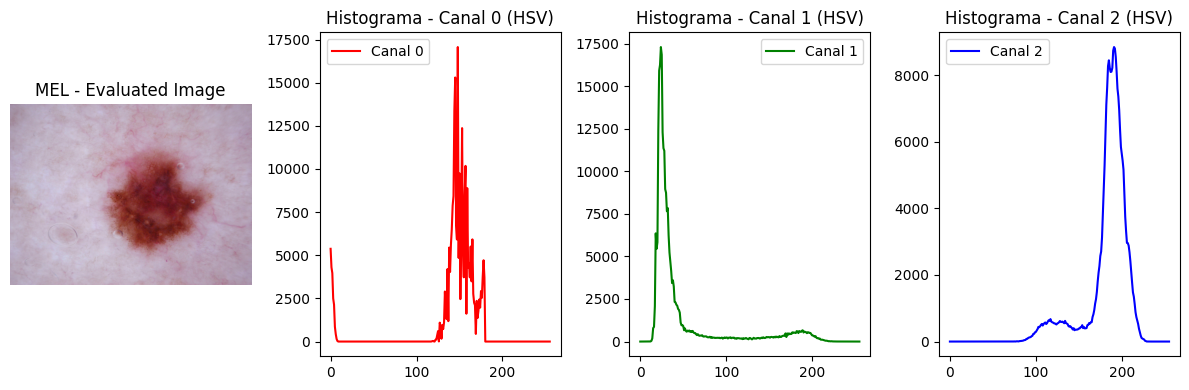

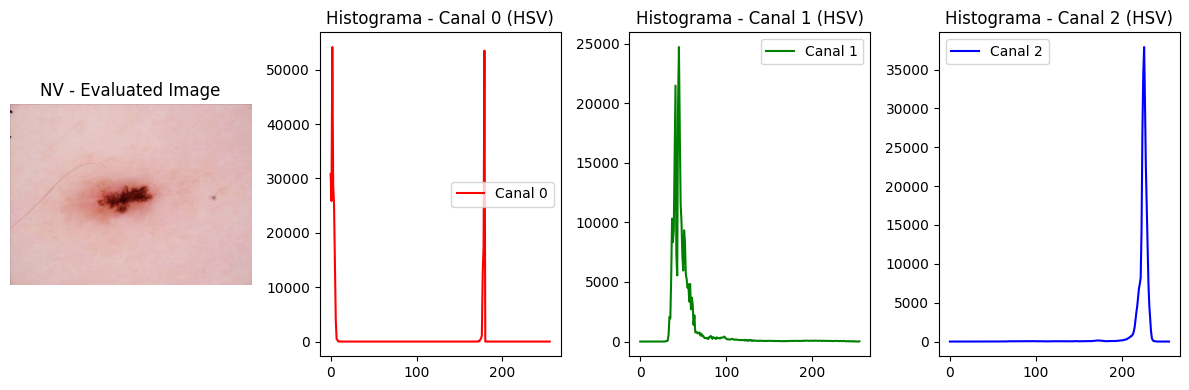

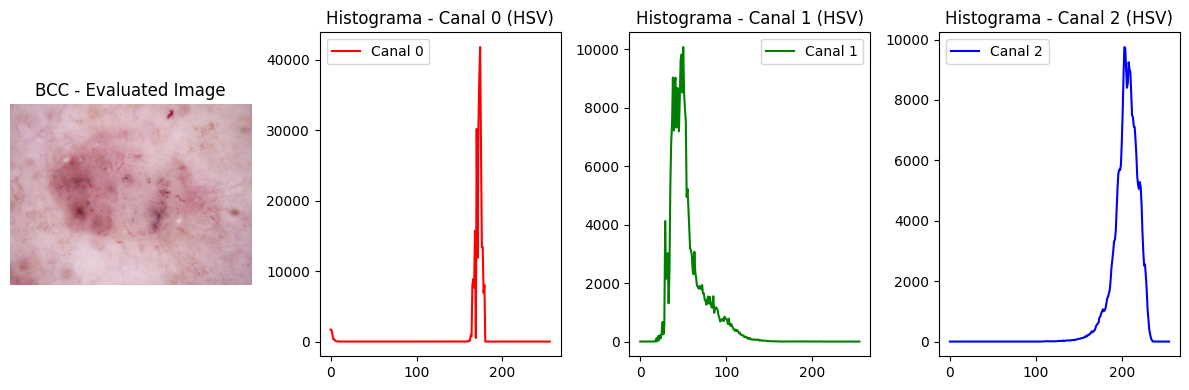

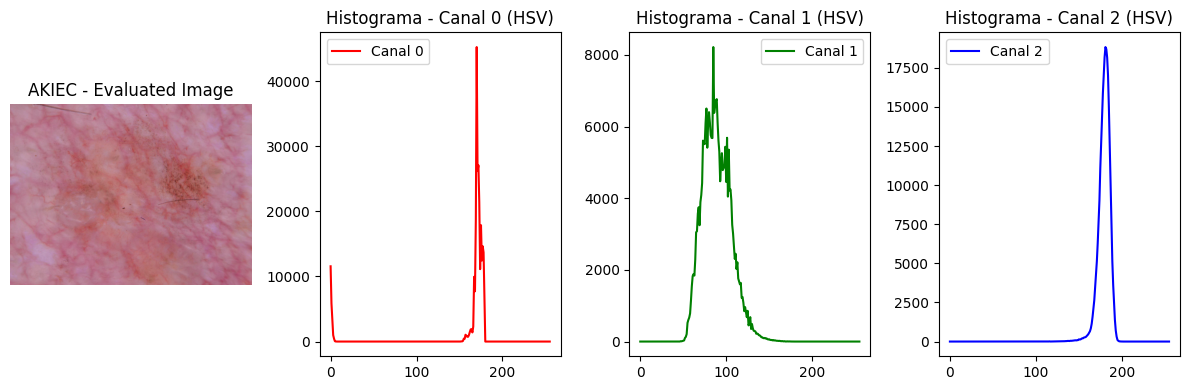

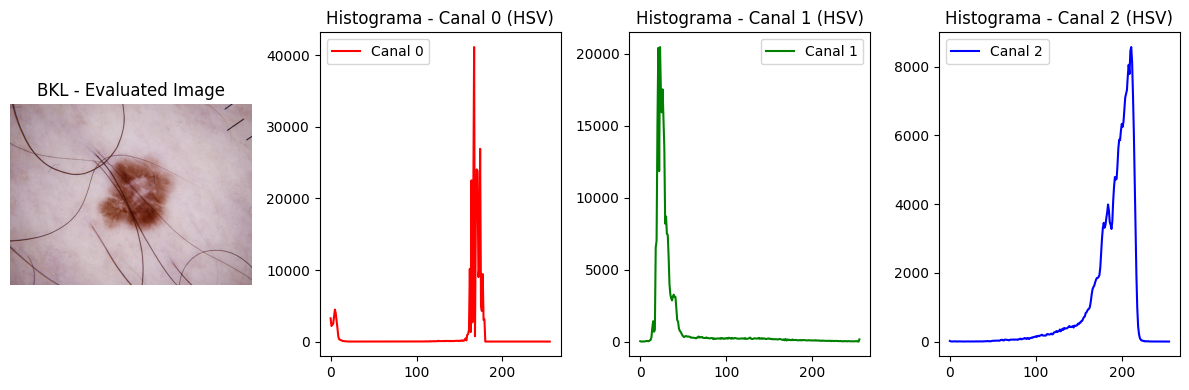

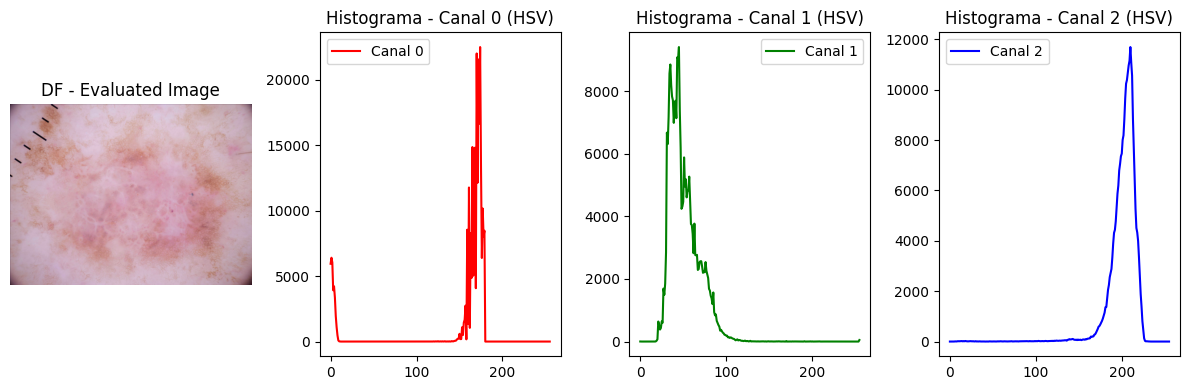

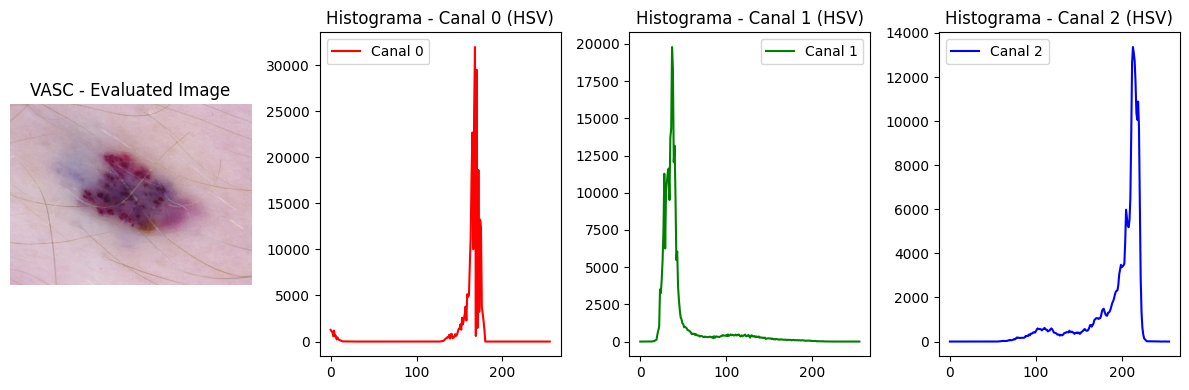

In [63]:
# Generar gráficos para cada tipo de lesión
for lesion_type, data in results.items():
    image_path = os.path.join(BASE_DIR/path_images, f"{random_images[lesion_type]}.jpg")
    histograms = data['histograms']
    display_image_and_histograms(lesion_type, image_path, histograms, color_space="HSV")

In [66]:
def generate_combined_summary_table(results):
    """
    Genera una tabla combinada con las métricas de todas las clases (lesiones).

    Parameters:
        results (dict): Diccionario con las métricas de cada clase.

    Returns:
        pd.DataFrame: DataFrame con las métricas organizadas por clase.
    """
    summary_data = {
        "Métrica": [
            "Hue (Media)", "Hue (Desviación estándar)", "Pico de Hue",
            "Saturation (Media)", "Saturation (Desviación estándar)",
            "Value (Media)", "Value (Desviación estándar)"
        ]
    }

    # Agregar columnas por cada tipo de lesión
    for lesion_type, data in results.items():
        stats = data['stats']
        hist_h, _, _ = data['histograms']
        h_peak = np.argmax(hist_h)

        summary_data[lesion_type] = [
            stats['channel_0_mean'],
            stats['channel_0_std'],
            h_peak,
            stats['channel_1_mean'],
            stats['channel_1_std'],
            stats['channel_2_mean'],
            stats['channel_2_std']
        ]

    # Crear el DataFrame
    summary_df = pd.DataFrame(summary_data)

    return summary_df

In [69]:
# Generar la tabla y mostrarla
summary_df = generate_combined_summary_table(results)

# Mostrar como Markdown
display(Markdown(summary_df.to_markdown(index=False)))

| Métrica                          |      MEL |       NV |      BCC |     AKIEC |      BKL |       DF |     VASC |
|:---------------------------------|---------:|---------:|---------:|----------:|---------:|---------:|---------:|
| Hue (Media)                      | 141.364  |  58.2012 | 168.991  | 157.682   | 151.369  | 148.798  | 161.162  |
| Hue (Desviación estándar)        |  40.8017 |  81.9776 |  24.3484 |  47.2444  |  51.0681 |  55.3441 |  28.3363 |
| Pico de Hue                      | 148      |   2      | 174      | 170       | 167      | 174      | 168      |
| Saturation (Media)               |  48.3975 |  52.1086 |  54.2041 |  89.0649  |  37.7599 |  50.7607 |  46.6485 |
| Saturation (Desviación estándar) |  48.0805 |  25.0215 |  19.7647 |  16.6071  |  34.9788 |  17.1337 |  30.8619 |
| Value (Media)                    | 183.563  | 222.896  | 205.232  | 179.511   | 190.259  | 202.199  | 195.259  |
| Value (Desviación estándar)      |  24.1329 |  15.6272 |  13.9726 |   6.74804 |  25.0134 |  15.2162 |  32.4652 |

In [72]:
def add_color_space_features_to_dataset(dataset, image_folder, color_space, prefix):
    """
    Calcula características estadísticas para cada imagen en un espacio de color y las agrega al dataset.
    
    Parameters:
        dataset (pd.DataFrame): Dataset original con una columna 'image' que identifica las imágenes.
        image_folder (str): Ruta de la carpeta que contiene las imágenes.
        color_space (str): Espacio de color ('HSV', 'LAB', etc.) compatible con OpenCV.
        prefix (str): Prefijo para las columnas del espacio de color en el dataset.

    Returns:
        pd.DataFrame: Dataset con características del espacio de color agregadas.
    """
    # Inicializar listas para almacenar las características
    channel_means = [[] for _ in range(3)]
    channel_stds = [[] for _ in range(3)]
    channel_peaks = [[] for _ in range(3)]

    for img_id in dataset['image']:
        # Ruta de la imagen
        img_path = os.path.join(image_folder, f"{img_id}.jpg")

        # Verificar si la imagen existe
        if os.path.exists(img_path):
            # Leer la imagen
            image = cv2.imread(img_path)
            if image is None:
                print(f"No se pudo cargar la imagen: {img_path}")
                for channel in range(3):
                    channel_means[channel].append(np.nan)
                    channel_stds[channel].append(np.nan)
                    channel_peaks[channel].append(np.nan)
                continue
            
            # Convertir al espacio de color especificado
            if color_space == 'HSV':
                converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LAB':
                converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            else:
                raise ValueError(f"Espacio de color no soportado: {color_space}")

            # Separar canales y calcular estadísticas
            channels = cv2.split(converted_image)
            for i, channel in enumerate(channels):
                channel_means[i].append(np.mean(channel))
                channel_stds[i].append(np.std(channel))
                hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
                channel_peaks[i].append(np.argmax(hist))
        else:
            print(f"No se encontró la imagen: {img_path}")
            for channel in range(3):
                channel_means[channel].append(np.nan)
                channel_stds[channel].append(np.nan)
                channel_peaks[channel].append(np.nan)

    # Agregar las características al dataset
    for i in range(3):
        dataset[f"{prefix}_channel_{i}_mean"] = channel_means[i]
        dataset[f"{prefix}_channel_{i}_std"] = channel_stds[i]
        dataset[f"{prefix}_channel_{i}_peak"] = channel_peaks[i]

    return dataset

##### Agregamos las caracteristicas obtenidas del espacio de color analizado con HSV

In [73]:
ground_truth = add_color_space_features_to_dataset(
    dataset=ground_truth, 
    image_folder=BASE_DIR/path_images, 
    color_space='HSV', 
    prefix='hsv'
)

In [74]:
def show_added_columns(dataset, prefix):
    """
    Muestra únicamente las columnas agregadas al dataset que tienen el prefijo especificado.

    Parameters:
        dataset (pd.DataFrame): Dataset completo con las columnas agregadas.
        prefix (str): Prefijo de las columnas agregadas por la función.

    Returns:
        pd.DataFrame: Subconjunto del dataset con solo las columnas agregadas.
    """
    # Filtrar las columnas que contienen el prefijo
    added_columns = [col for col in dataset.columns if col.startswith(prefix)]
    return dataset[added_columns]  # Mostrar las primeras filas de esas columnas



In [75]:
# Mostrar las columnas agregadas con un prefijo específico
added_columns_df = show_added_columns(ground_truth, prefix="hsv")
added_columns_df.head()

hsv_channel_0_mean  hsv_channel_0_std  hsv_channel_0_peak  \
0           78.139256          87.370640                   0   
1          130.303393          77.785119                 178   
2           81.811926          87.347425                 178   
3          161.096467          49.154544                 177   
4           74.559000          84.311637                   0   

   hsv_channel_1_mean  hsv_channel_1_std  hsv_channel_1_peak  \
0          121.778559          27.888949                 102   
1          110.085241          19.747560                 105   
2          113.621600          47.766647                  77   
3          116.153930          25.479114                 106   
4           97.503078          31.638918                  73   

   hsv_channel_2_mean  hsv_channel_2_std  hsv_channel_2_peak  
0          214.742830          28.007025                 228  
1          216.408637          12.425810                 222  
2          211.505348          41.338153                 247  
3          193.472681          18.422840                 197  
4          201.132767          29.092036                 208

#### CIELAB

In [76]:
def display_image_with_histograms(lesion_type, image_path, histograms, color_space):
    """
    Muestra una imagen y sus histogramas para cada canal en un espacio de color.
    
    Parameters:
        lesion_type (str): Tipo de lesión.
        image_path (str): Ruta de la imagen.
        histograms (list): Lista de histogramas para cada canal.
        color_space (str): Espacio de color usado ('HSV', 'LAB', etc.).
    """
    # Cargar y convertir la imagen para visualización
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crear la figura
    plt.figure(figsize=(16, 4))
    
    # Mostrar la imagen
    plt.subplot(1, 4, 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"{lesion_type} - {color_space} - Selected Image")
    
    # Mostrar los histogramas para cada canal
    colors = ['r', 'g', 'b'] if color_space == 'HSV' else ['y', 'c', 'm']
    for i, hist in enumerate(histograms):
        plt.subplot(1, 4, i + 2)
        plt.plot(hist, color=colors[i])
        plt.title(f"{lesion_type} - {color_space} - Channel {i} Histogram")
    
    plt.tight_layout()
    plt.show()

Procesando MEL - ISIC_0034107
Procesando NV - ISIC_0027197
Procesando BCC - ISIC_0026442
Procesando AKIEC - ISIC_0027650
Procesando BKL - ISIC_0029522
Procesando DF - ISIC_0026789
Procesando VASC - ISIC_0030882


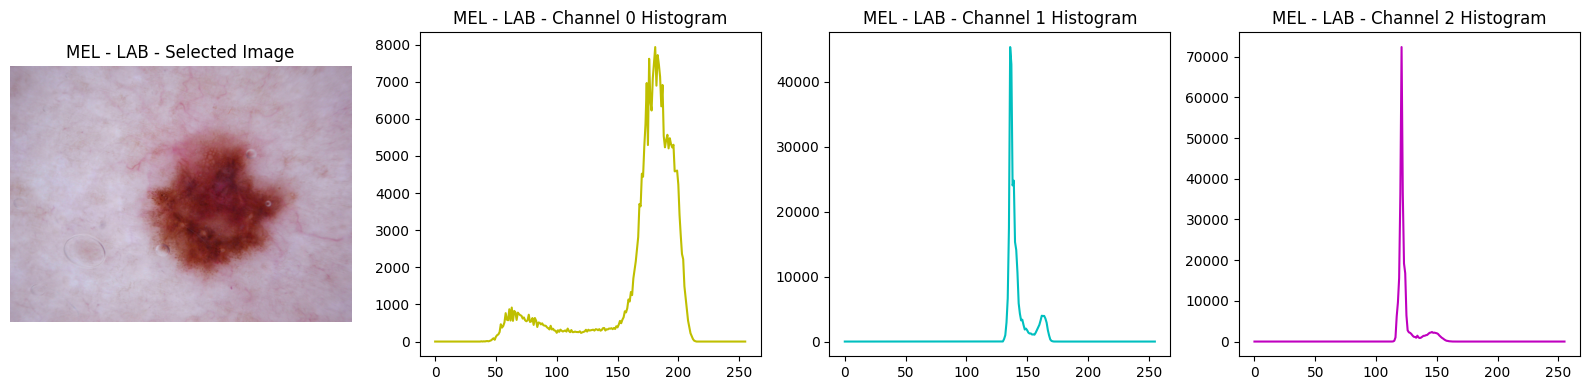

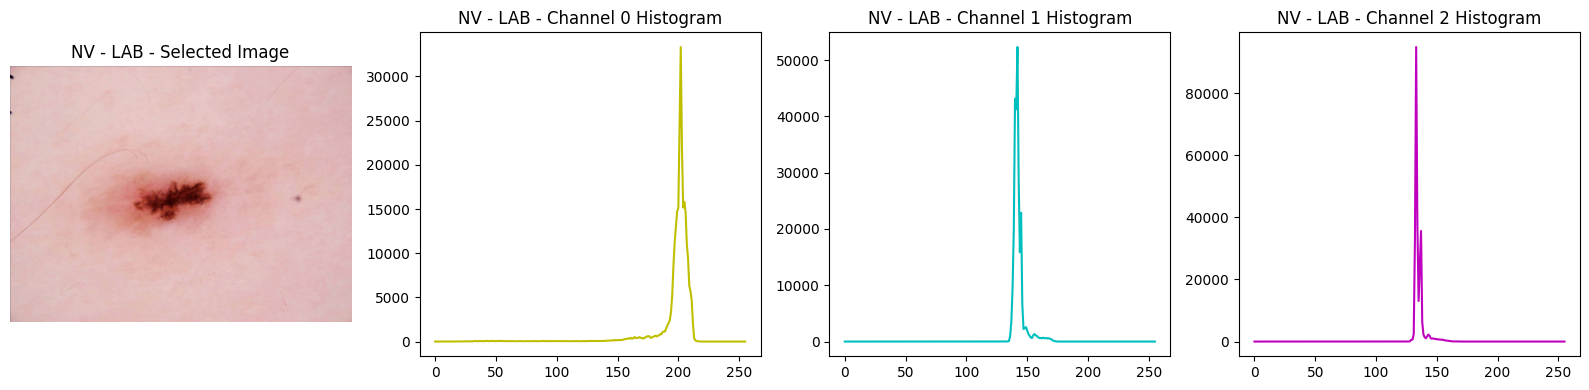

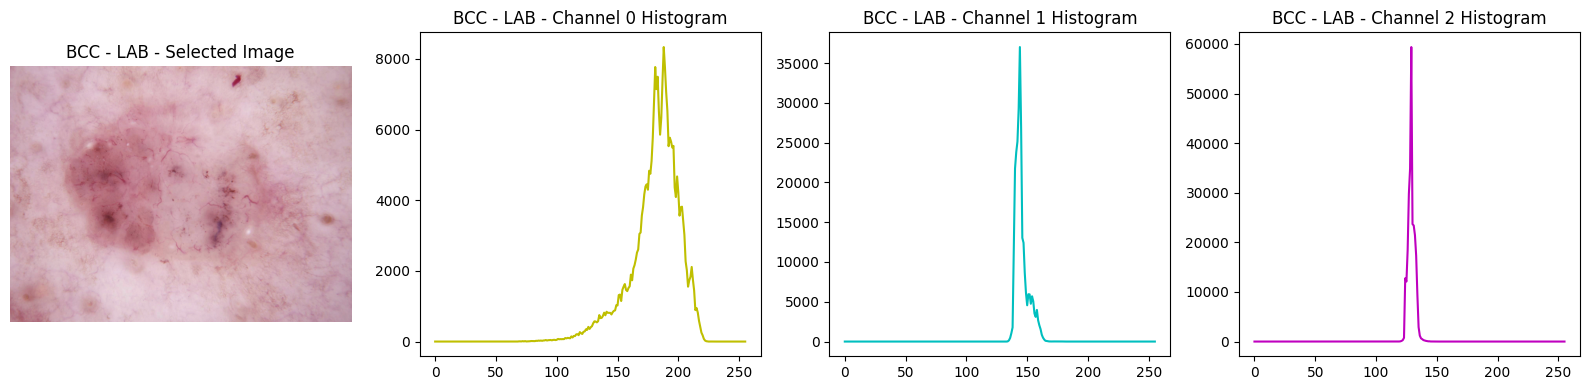

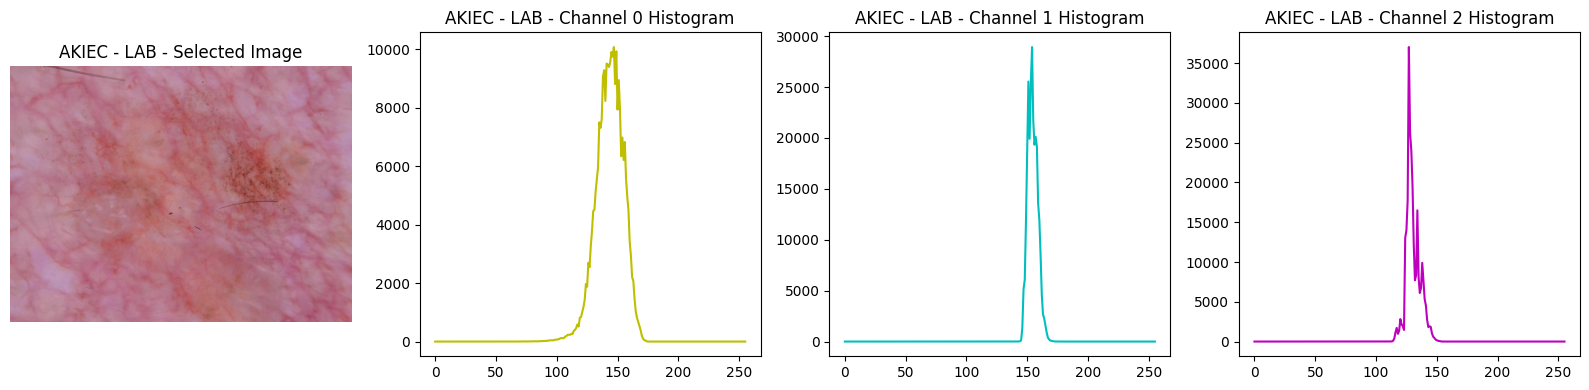

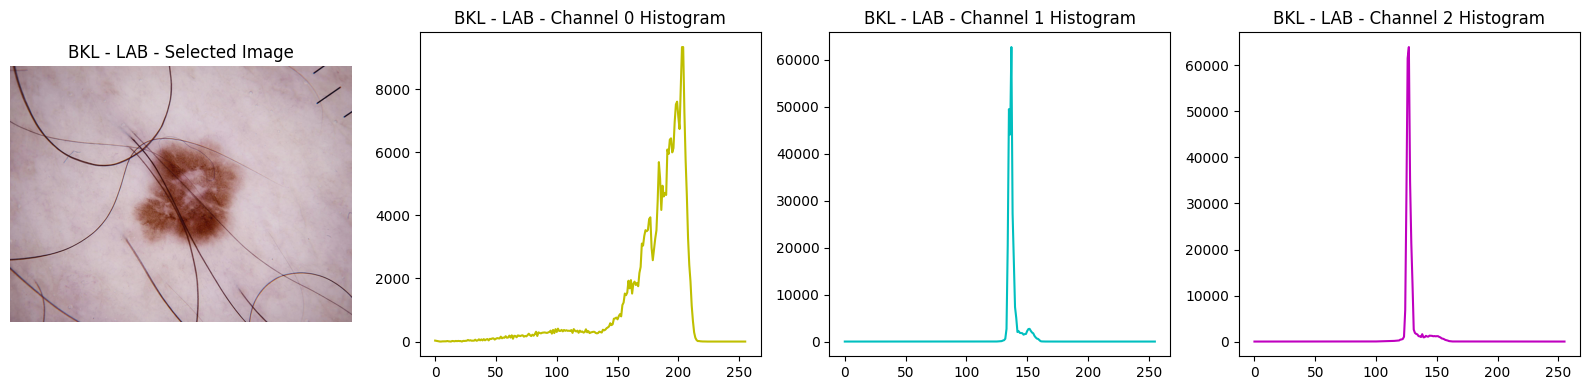

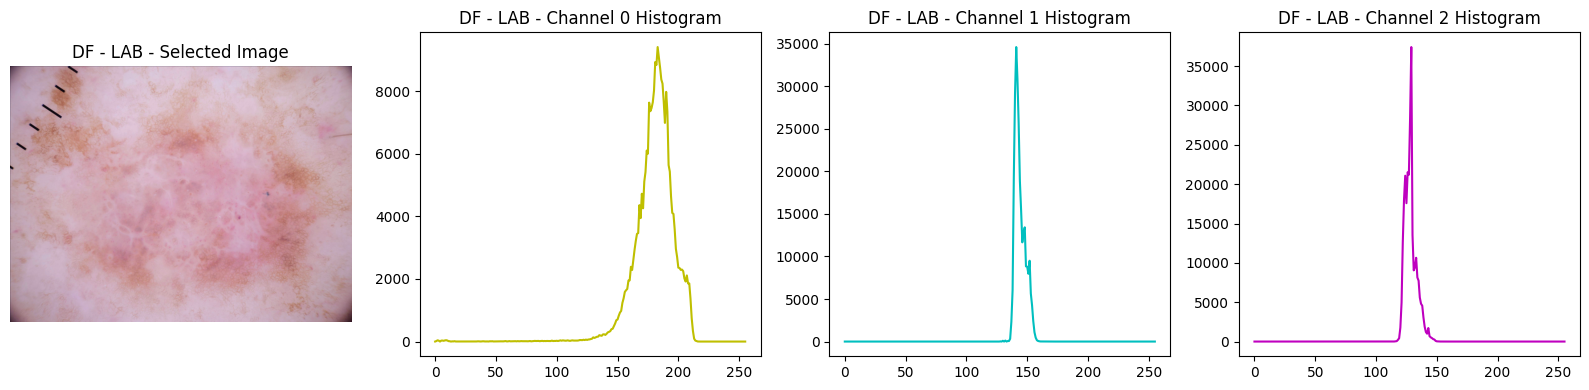

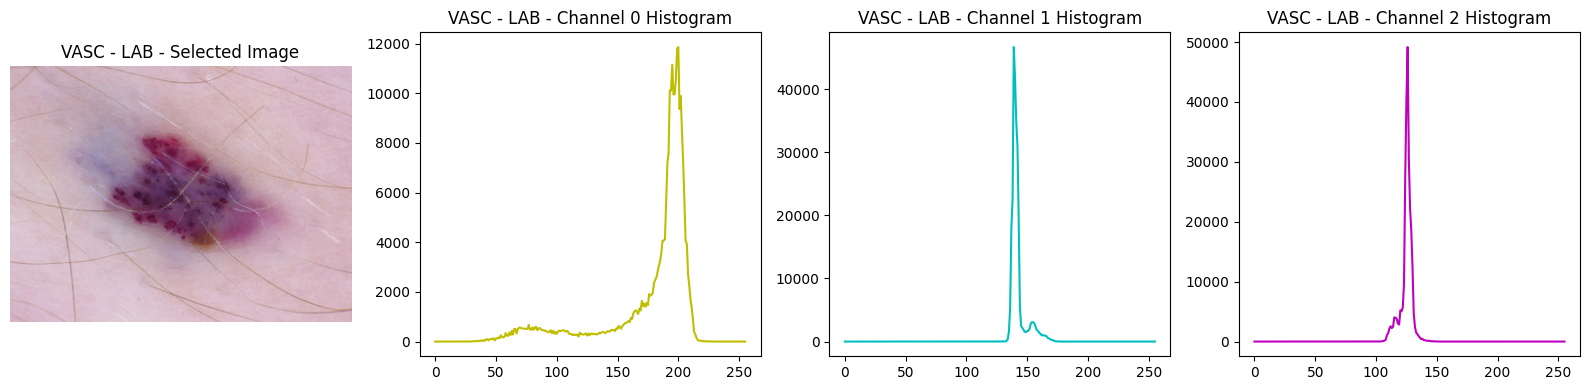

In [77]:
# Procesar cada imagen seleccionada para LAB
results_color_analysis = {}
for lesion_type, image_id in random_images.items():
    image_path = os.path.join(BASE_DIR/path_images, f"{image_id}.jpg")
    if os.path.exists(image_path):
        print(f"Procesando {lesion_type} - {image_id}")
        histograms, stats = analyze_color_space(image_path, color_space='LAB')
        results_color_analysis[lesion_type] = {
            'image_path': image_path,
            'histograms': histograms,
            'stats': stats
        }
    else:
        print(f"No se encontró la imagen {image_path}")

# Mostrar resultados para cada tipo de lesión
for lesion_type, data in results_color_analysis.items():
    display_image_with_histograms(
        lesion_type,
        data['image_path'],
        data['histograms'],
        color_space='LAB'
    )

In [78]:
def display_lab_summary_table(results):
    """
    Muestra un resumen en formato de tabla para el análisis LAB con todas las clases en columnas.
    
    Parameters:
        results (dict): Diccionario con los resultados de estadísticas y histogramas por tipo de lesión.
    """
    import pandas as pd

    # Inicializar un diccionario para almacenar las métricas
    table_data = {
        "Métrica": [
            "Media (L)", "Desviación estándar (L)",
            "Media (A)", "Desviación estándar (A)",
            "Media (B)", "Desviación estándar (B)"
        ]
    }

    # Iterar sobre los resultados para llenar los valores
    for lesion_type, data in results.items():
        stats = data['stats']
        table_data[lesion_type] = [
            f"{stats['channel_0_mean']:.2f}", f"{stats['channel_0_std']:.2f}",
            f"{stats['channel_1_mean']:.2f}", f"{stats['channel_1_std']:.2f}",
            f"{stats['channel_2_mean']:.2f}", f"{stats['channel_2_std']:.2f}"
        ]

    # Convertir los datos en un DataFrame para visualización
    summary_df = pd.DataFrame(table_data)

    # Mostrar la tabla
    from IPython.display import display, Markdown
    display(Markdown("### Resumen del Análisis LAB"))
    display(summary_df)

In [79]:
# Llamar a la función con los resultados calculados
display_lab_summary_table(results)

### Resumen del Análisis LAB

Métrica     MEL      NV     BCC   AKIEC     BKL      DF  \
0                Media (L)  141.36   58.20  168.99  157.68  151.37  148.80   
1  Desviación estándar (L)   40.80   81.98   24.35   47.24   51.07   55.34   
2                Media (A)   48.40   52.11   54.20   89.06   37.76   50.76   
3  Desviación estándar (A)   48.08   25.02   19.76   16.61   34.98   17.13   
4                Media (B)  183.56  222.90  205.23  179.51  190.26  202.20   
5  Desviación estándar (B)   24.13   15.63   13.97    6.75   25.01   15.22   

     VASC  
0  161.16  
1   28.34  
2   46.65  
3   30.86  
4  195.26  
5   32.47

In [80]:
ground_truth = add_color_space_features_to_dataset(
    dataset=ground_truth, 
    image_folder=BASE_DIR/path_images, 
    color_space='LAB', 
    prefix='lab'
)

In [81]:
# Mostrar las columnas agregadas con un prefijo específico
added_columns_df = show_added_columns(ground_truth, prefix="lab")
added_columns_df.head()

lab_channel_0_mean  lab_channel_0_std  lab_channel_0_peak  \
0          154.359426          28.508517                 173   
1          159.271944          16.382503                 168   
2          159.633070          45.710142                 193   
3          141.379459          21.276072                 156   
4          159.454130          30.357068                 170   

   lab_channel_1_mean  lab_channel_1_std  lab_channel_1_peak  \
0          165.837119           5.172936                 164   
1          164.377411           4.810767                 165   
2          160.410137           7.118047                 155   
3          163.283133           5.464763                 163   
4          153.869300           4.427611                 153   

   lab_channel_2_mean  lab_channel_2_std  lab_channel_2_peak  
0          145.147163           5.655364                 143  
1          140.654852           5.500798                 138  
2          143.442070           9.027196                 137  
3          137.865293           2.782220                 138  
4          140.564244           9.238856                 137

### 2. Identificar patrones cromáticos predominantes

In [82]:
def analyze_color_distribution(image_path):
    """
    Calcula los histogramas de color para cada canal (R, G, B) y extrae patrones cromáticos predominantes.
    
    Parameters:
        image_path (str): Ruta de la imagen a analizar.
    
    Returns:
        dict: Estadísticas del histograma (pico y posición) y los histogramas para cada canal.
    """
    # Leer la imagen
    image = cv2.imread(image_path)
    if image is None:
        print(f"No se pudo cargar la imagen: {image_path}")
        return None
    
    # Convertir la imagen de BGR a RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calcular histogramas para cada canal (R, G, B)
    histograms = {}
    stats = {}
    channels = ['R', 'G', 'B']
    for i, channel in enumerate(cv2.split(image_rgb)):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        histograms[channels[i]] = hist
        stats[f"{channels[i]}_peak"] = int(np.argmax(hist))  # Posición del pico
        stats[f"{channels[i]}_freq"] = int(hist[stats[f"{channels[i]}_peak"]][0])  # Extraer el valor escalar
    
    return {
        "histograms": histograms,
        "stats": stats
    }

In [83]:
# Diccionario para almacenar resultados
color_distribution_results = {}

# Procesar imágenes seleccionadas
for lesion_type, image_id in random_images.items():
    image_path = os.path.join(BASE_DIR/path_images, f"{image_id}.jpg")
    if os.path.exists(image_path):
        print(f"Procesando {lesion_type} - {image_id}")
        result = analyze_color_distribution(image_path)
        if result:
            color_distribution_results[lesion_type] = {
                "image_path": image_path,
                "histograms": result["histograms"],
                "stats": result["stats"]
            }
    else:
        print(f"No se encontró la imagen: {image_path}")

Procesando MEL - ISIC_0034107
Procesando NV - ISIC_0027197
Procesando BCC - ISIC_0026442
Procesando AKIEC - ISIC_0027650
Procesando BKL - ISIC_0029522
Procesando DF - ISIC_0026789
Procesando VASC - ISIC_0030882


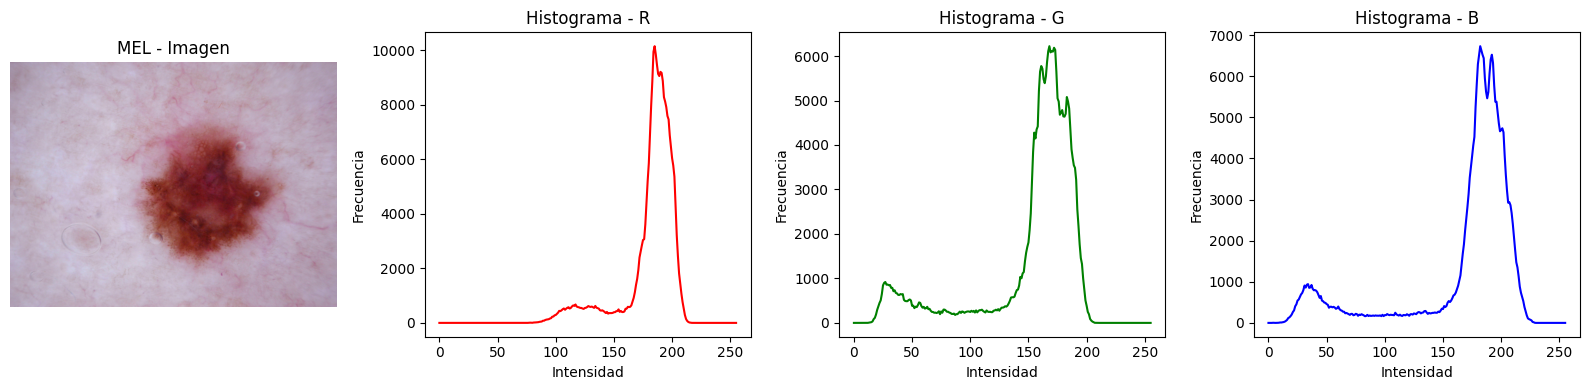

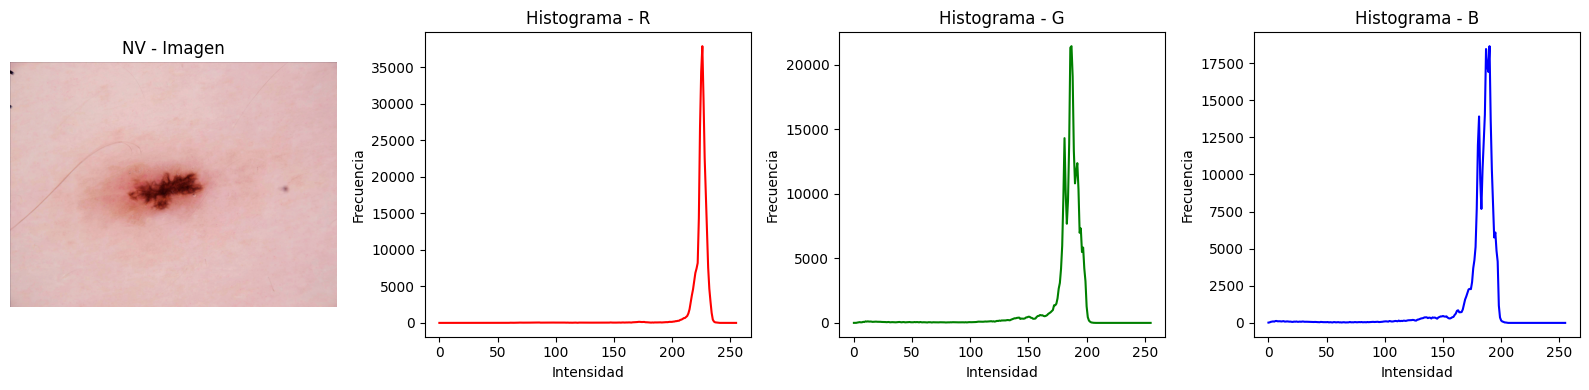

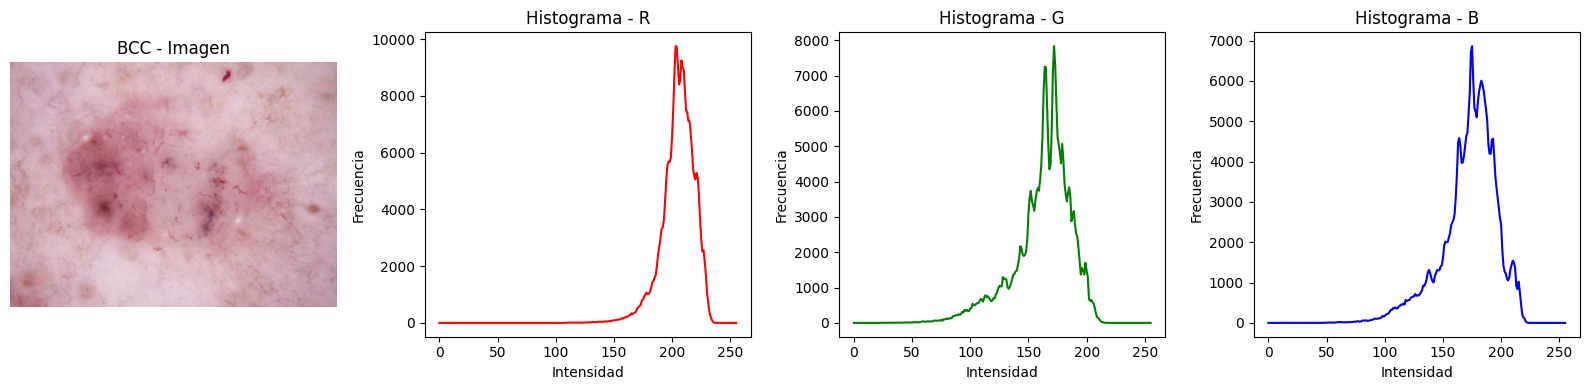

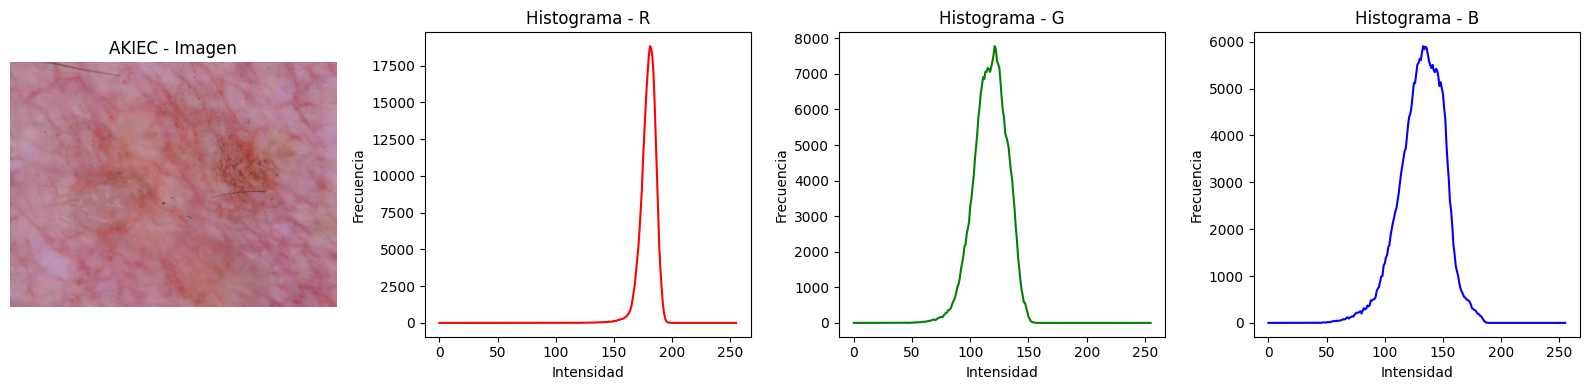

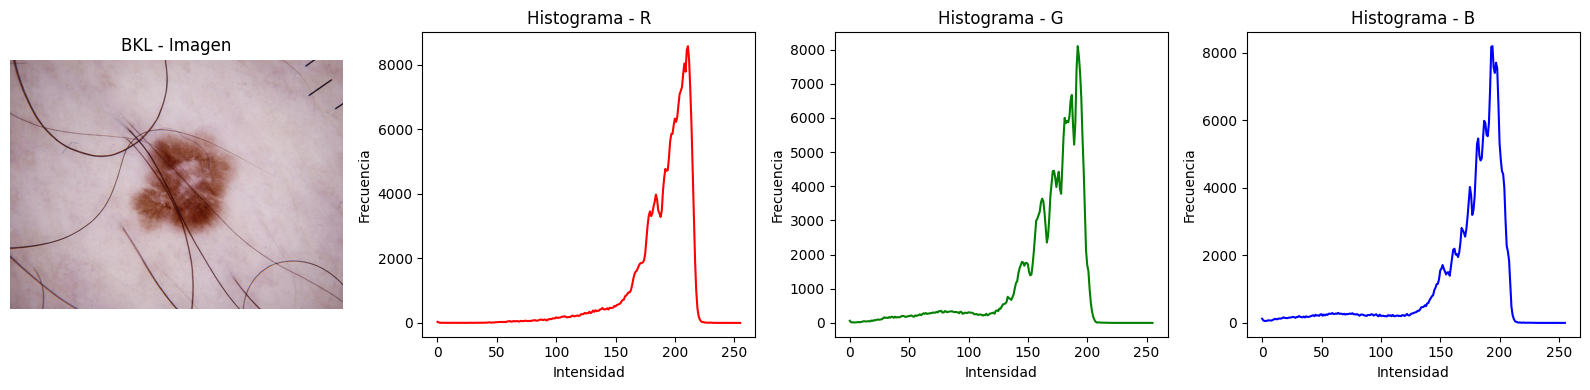

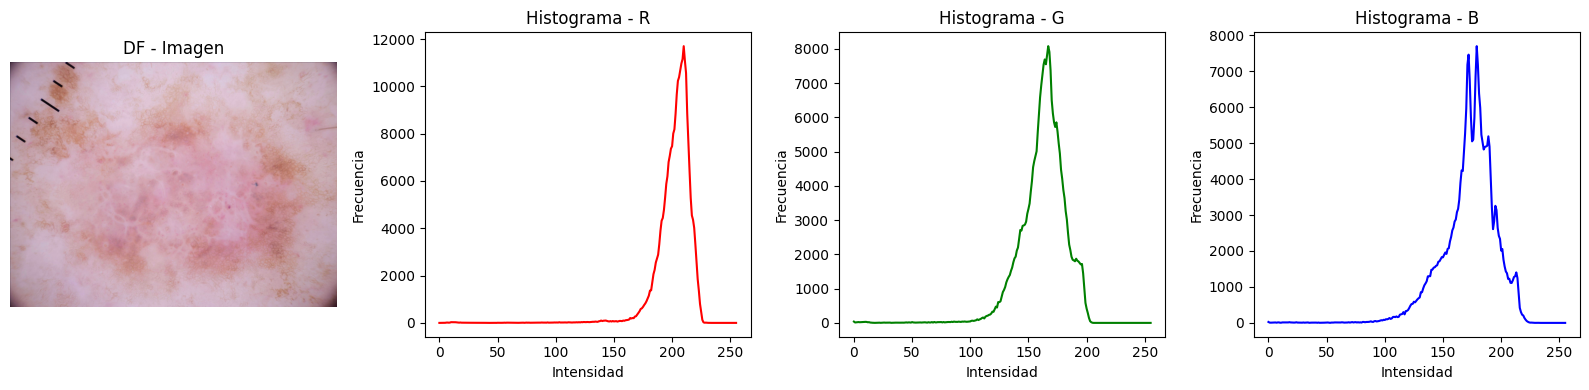

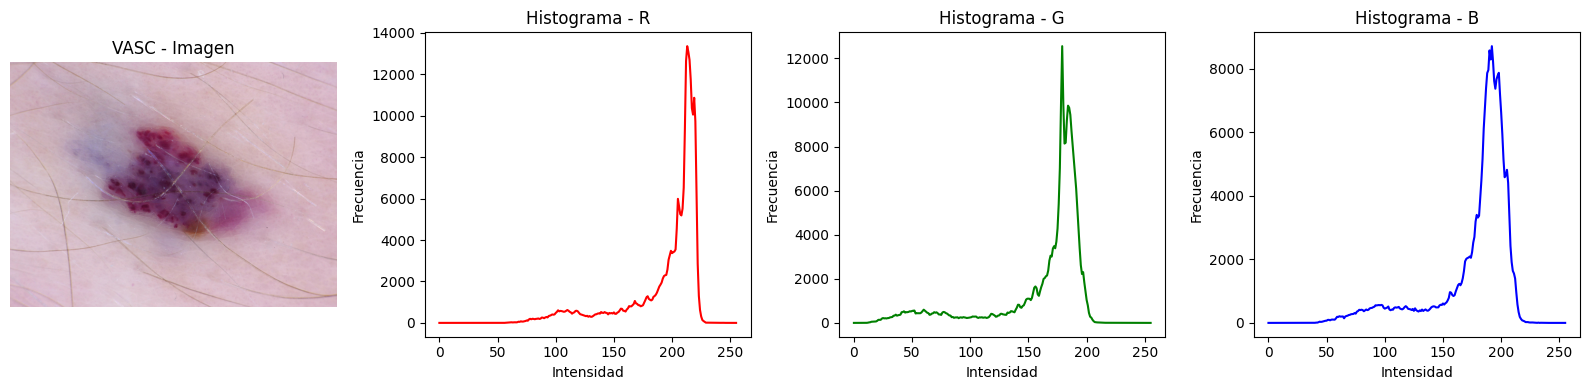

In [84]:
def display_image_with_rgb_histograms(lesion_type, image_path, histograms):
    """
    Muestra una imagen y sus histogramas de color (R, G, B) en una sola fila.
    
    Parameters:
        lesion_type (str): Tipo de lesión.
        image_path (str): Ruta de la imagen.
        histograms (dict): Histogramas de los canales (R, G, B).
    """
    # Cargar la imagen
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crear la figura
    plt.figure(figsize=(16, 4))  # Ajustar tamaño para una fila horizontal

    # Mostrar la imagen
    plt.subplot(1, 4, 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"{lesion_type} - Imagen")

    # Mostrar los histogramas
    colors = ['r', 'g', 'b']
    channels = ['R', 'G', 'B']
    for i, channel in enumerate(channels):
        plt.subplot(1, 4, i + 2)
        plt.plot(histograms[channel], color=colors[i])
        plt.title(f"Histograma - {channel}")
        plt.xlabel("Intensidad")
        plt.ylabel("Frecuencia")
    
    plt.tight_layout()
    plt.show()

# Visualizar resultados para cada clase
for lesion_type, data in color_distribution_results.items():
    display_image_with_rgb_histograms(
        lesion_type=lesion_type,
        image_path=data["image_path"],
        histograms=data["histograms"]
    )

In [85]:
def add_rgb_histogram_features_to_dataset(dataset, image_folder):
    """
    Calcula los picos de los histogramas RGB y sus frecuencias, agregándolos al dataset.
    
    Parameters:
        dataset (pd.DataFrame): Dataset original con una columna 'image' que identifica las imágenes.
        image_folder (str): Ruta de la carpeta que contiene las imágenes.

    Returns:
        pd.DataFrame: Dataset actualizado con las características RGB agregadas.
    """
    # Inicializar listas para almacenar características
    r_peak_list, r_freq_list = [], []
    g_peak_list, g_freq_list = [], []
    b_peak_list, b_freq_list = [], []

    for img_id in dataset['image']:
        # Ruta de la imagen
        img_path = os.path.join(image_folder, f"{img_id}.jpg")

        # Verificar si la imagen existe
        if os.path.exists(img_path):
            # Calcular características de distribución de color
            result = analyze_color_distribution(img_path)
            if result:
                stats = result['stats']
                r_peak_list.append(stats['R_peak'])
                r_freq_list.append(stats['R_freq'])
                g_peak_list.append(stats['G_peak'])
                g_freq_list.append(stats['G_freq'])
                b_peak_list.append(stats['B_peak'])
                b_freq_list.append(stats['B_freq'])
            else:
                # Si no hay resultados, agregar valores NaN
                r_peak_list.append(np.nan)
                r_freq_list.append(np.nan)
                g_peak_list.append(np.nan)
                g_freq_list.append(np.nan)
                b_peak_list.append(np.nan)
                b_freq_list.append(np.nan)
        else:
            print(f"No se encontró la imagen: {img_path}")
            r_peak_list.append(np.nan)
            r_freq_list.append(np.nan)
            g_peak_list.append(np.nan)
            g_freq_list.append(np.nan)
            b_peak_list.append(np.nan)
            b_freq_list.append(np.nan)

    # Agregar columnas al dataset
    dataset['R_peak'] = r_peak_list
    dataset['R_freq'] = r_freq_list
    dataset['G_peak'] = g_peak_list
    dataset['G_freq'] = g_freq_list
    dataset['B_peak'] = b_peak_list
    dataset['B_freq'] = b_freq_list

    return dataset

In [86]:
# agregamos la información proporcionada por el cálculo de los picos de los histogramas al dataset
ground_truth = add_rgb_histogram_features_to_dataset(
    dataset=ground_truth,
    image_folder=BASE_DIR/path_images
)

In [87]:
ground_truth.filter(regex=r'^(R_peak|R_freq|G_peak|G_freq|B_peak|B_freq)').head() # resulado de agregarle el cálculo de los picos al dataset

R_peak  R_freq  G_peak  G_freq  B_peak  B_freq
0     228   10063     139    9529     136    6697
1     222   13192     132    8513     141    7367
2     247   12076     168    7410     168    5367
3     197    9751     122    8558     126    7568
4     208    9795     146    6212     148    3449

#### Plan para Detección de Anomalías o Regularidades en las Distribuciones Cromáticas

1. **Análisis Estadístico**
- Visualizar la distribución de las características cromáticas (picos y frecuencias de los histogramas) para cada tipo de lesión.
- Comparar estas distribuciones entre clases para detectar diferencias significativas.

2. **Identificación de Outliers**
- Usar métodos estadísticos como el rango intercuartil (IQR) o Z-score para identificar valores atípicos.
- Evaluar qué imágenes presentan valores fuera de los límites establecidos para cada característica.

3. **Visualización de Resultados**
- Utilizar gráficos de cajas (boxplots) para comparar características entre clases.
- Resaltar los outliers en los gráficos y observar su distribución.

4. **Interpretación**
- Determinar si los patrones encontrados pueden ser relevantes para la clasificación o diagnóstico.
- Usar los insights para enriquecer el dataset y entrenar modelos de aprendizaje automático.

---

**Objetivos del Paso**
1. Identificar patrones cromáticos comunes o significativos entre las clases de lesiones.
2. Detectar imágenes con valores anómalos que puedan representar casos únicos o ruido en los datos.
3. Proporcionar un marco de análisis que permita mejorar el entendimiento y la clasificación de las lesiones.

In [88]:
# Crear la columna 'lesion_type' basada en las columnas de clase
class_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Crear una nueva columna que indique el tipo de lesión
ground_truth['lesion_type'] = ground_truth[class_columns].idxmax(axis=1)

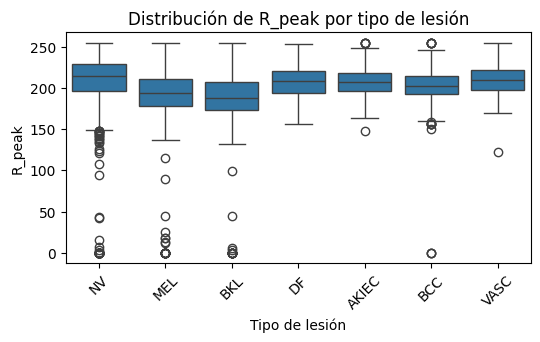

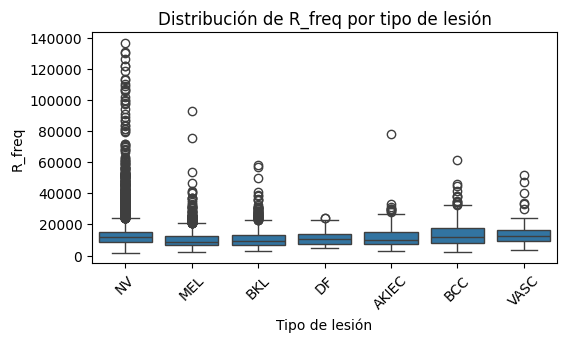

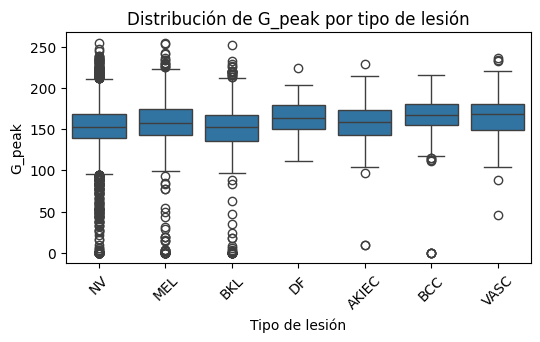

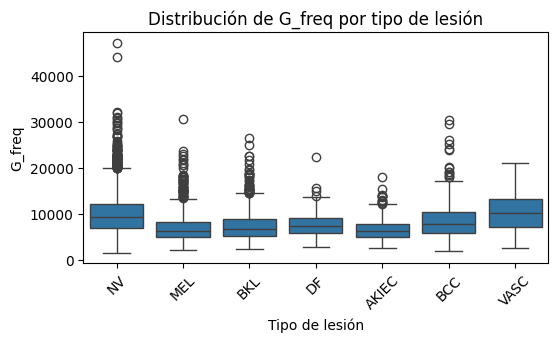

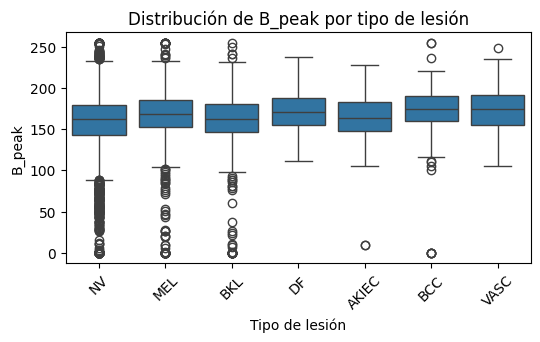

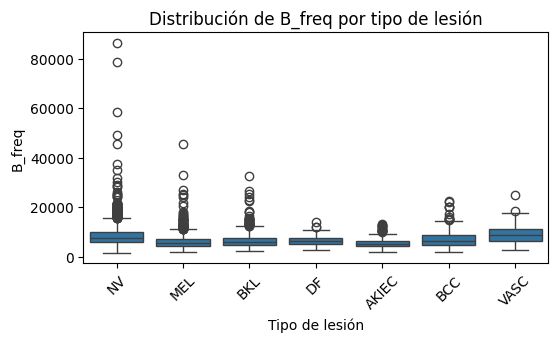

In [92]:
# Análisis Estadístico y Visualización
def visualize_color_distributions(dataset, feature, hue="lesion_type"):
    """
    Visualiza la distribución de una característica cromática por tipo de lesión.
    
    Parameters:
        dataset (pd.DataFrame): Dataset con las características cromáticas.
        feature (str): Nombre de la característica a analizar.
        hue (str): Variable para dividir los datos (e.g., tipo de lesión).
    """
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=dataset, x=hue, y=feature)
    plt.title(f"Distribución de {feature} por tipo de lesión")
    plt.xticks(rotation=45)
    plt.ylabel(feature)
    plt.xlabel("Tipo de lesión")
    plt.show()

# Visualizar distribuciones para cada característica
color_features = ['R_peak', 'R_freq', 'G_peak', 'G_freq', 'B_peak', 'B_freq']
for feature in color_features:
    visualize_color_distributions(ground_truth, feature)

#### **Conclusiones del Análisis de Histogramas por Tipo de Lesión**

##### 1. **Canal Rojo** (`R_peak` y `R_freq`)
- **Relevancia:** El canal rojo es el más relevante debido a su mayor consistencia en ciertas clases y mayor variabilidad en otras.
- **Clases Consistentes:**
  - **BCC** (Carcinoma Basocelular) y **AKIEC** (Carcinoma Escamoso) tienen distribuciones más uniformes, con menor dispersión.
- **Clases Variables:**
  - **NV** (Nevus) muestra alta variabilidad y numerosos outliers, indicando heterogeneidad en las tonalidades rojas dentro de estas lesiones.
- **Frecuencias:**
  - **NV** presenta frecuencias extremadamente altas en algunas imágenes, lo que podría representar dominancia de ciertas tonalidades rojas en este tipo de lesiones.

##### 2. **Canal Verde y Azul** (`G_peak`, `G_freq`, `B_peak`, `B_freq`)
- **Menor Relevancia:** Los canales verde y azul presentan menor variabilidad general en comparación con el rojo.
- **Distribuciones Uniformes:**
  - **BCC** y **VASC** tienen distribuciones más consistentes en ambos canales.
- **Variabilidad:**
  - **NV** y **BKL** presentan mayor cantidad de outliers hacia tonalidades bajas, lo que indica posibles variaciones en la pigmentación de estas lesiones.

##### 3. **Outliers**
- Los outliers son predominantes en las clases **NV** y **BKL**, especialmente en las frecuencias (`R_freq`, `G_freq`, `B_freq`).
- Podrían representar:
  - Casos interesantes para análisis más detallados, como segmentación o evaluación de texturas.
  - Imágenes con iluminación o características cromáticas únicas.

##### 4. **Relevancia de los Canales**
- **Canal Rojo:** Es el canal más relevante para identificar patrones consistentes o detectar heterogeneidad entre las clases.
- **Canal Verde y Azul:** Menos relevantes por sí solos, pero pueden complementar el análisis cuando se combinan con el canal rojo.

---

### 3. Extracción de Características Cromáticas

En esta sección, nos enfocamos en extraer métricas avanzadas que describen la distribución cromática de las imágenes en diferentes canales de color (RGB, HSV, LAB). Estas características tienen el potencial de capturar información relevante para diferenciar las clases de lesiones y enriquecer el dataset con datos significativos.

#### **¿Por qué incluir la varianza y asimetría?**

1. **Varianza (Segundo Momento)**
La **varianza** mide la dispersión de los valores de color en un canal. Es una métrica estadística fundamental para evaluar la homogeneidad o heterogeneidad en la tonalidad de una lesión. 
- **Lesiones homogéneas** (por ejemplo, algunas lesiones de tipo BCC) tendrán una varianza baja, indicando una distribución uniforme de color.
- **Lesiones heterogéneas** (por ejemplo, nevus o melanomas) tendrán una varianza alta debido a la mezcla de tonos dentro de la lesión.

**Ejemplo:**  
Una lesión con bordes difusos y múltiples tonalidades tendrá una varianza significativamente mayor en comparación con una lesión uniforme de un solo color.

2. **Asimetría (Skewness, Tercer Momento)**
La **asimetría** describe el sesgo de la distribución de los colores en un canal. Es particularmente útil para identificar si los valores de color están:
- Sesgados hacia tonalidades más claras (valores altos en el canal).
- Sesgados hacia tonalidades más oscuras (valores bajos en el canal).

Esto puede ser relevante porque algunas lesiones tienden a concentrarse en tonalidades específicas (por ejemplo, tonos oscuros en melanomas o tonos claros en lesiones benignas).

**Ejemplo:**  
Si el canal rojo de una imagen tiene una alta asimetría positiva, esto podría indicar una concentración de tonos rojizos intensos, típicos en lesiones vasculares.

---

#### Justificación de su Inclusión
1. **Captura de Patrones Complejos:**
   - Varianza y asimetría permiten capturar aspectos avanzados de la distribución cromática que no son evidentes al observar solo la media o el valor pico.

2. **Diferenciación entre Clases:**
   - Las lesiones de diferentes clases presentan variaciones en su estructura y coloración que pueden reflejarse en estas métricas.

3. **Relevancia para Modelos de Clasificación:**
   - Estas características pueden ser utilizadas como entradas en modelos de aprendizaje automático, ayudando a los algoritmos a identificar patrones únicos en cada clase.

4. **Exploración Cromática Completa:**
   - Junto con la media, desviación estándar y los valores máximos/mínimos, la varianza y asimetría enriquecen la representación estadística de cada imagen.

---

#### Objetivos
- Calcular la varianza y asimetría de los canales de color para cada imagen del dataset.
- Incorporar estas métricas al dataset como nuevas columnas.
- Evaluar su relevancia en el análisis cromático y su impacto en tareas de clasificación.

In [93]:
# calculamos la varianza y asimetría
def calculate_color_features(image_channel):
    """
    Calcula la media, varianza, y asimetría de un canal de color.
    
    Parameters:
        image_channel (ndarray): Canal de color de la imagen.
    
    Returns:
        dict: Diccionario con la media, varianza, y skewness.
    """
    features = {
        'mean': np.mean(image_channel),
        'variance': np.var(image_channel),
        'skewness': skew(image_channel.flatten())
    }
    return features

In [94]:
def add_variance_and_skewness_to_dataset(dataset, image_folder):
    """
    Calcula varianza y asimetría para cada imagen en el dataset y las agrega como nuevas columnas.
    
    Parameters:
        dataset (pd.DataFrame): Dataset original con una columna 'image'.
        image_folder (str): Ruta de la carpeta que contiene las imágenes.
    
    Returns:
        pd.DataFrame: Dataset con varianza y skewness agregadas.
    """
    # Inicializar listas para almacenar las características
    r_variance, r_skewness = [], []
    g_variance, g_skewness = [], []
    b_variance, b_skewness = [], []

    for img_id in dataset['image']:
        # Ruta de la imagen
        img_path = os.path.join(image_folder, f"{img_id}.jpg")

        if os.path.exists(img_path):
            # Leer la imagen
            image = cv2.imread(img_path)
            if image is None:
                print(f"No se pudo cargar la imagen: {img_path}")
                continue
            
            # Separar los canales de color
            b_channel, g_channel, r_channel = cv2.split(image)

            # Calcular métricas para cada canal
            r_features = calculate_color_features(r_channel)
            g_features = calculate_color_features(g_channel)
            b_features = calculate_color_features(b_channel)

            # Almacenar las métricas
            r_variance.append(r_features['variance'])
            r_skewness.append(r_features['skewness'])
            g_variance.append(g_features['variance'])
            g_skewness.append(g_features['skewness'])
            b_variance.append(b_features['variance'])
            b_skewness.append(b_features['skewness'])
        else:
            print(f"No se encontró la imagen: {img_path}")
            r_variance.append(np.nan)
            r_skewness.append(np.nan)
            g_variance.append(np.nan)
            g_skewness.append(np.nan)
            b_variance.append(np.nan)
            b_skewness.append(np.nan)

    # Agregar las nuevas columnas al dataset
    dataset['R_variance'] = r_variance
    dataset['R_skewness'] = r_skewness
    dataset['G_variance'] = g_variance
    dataset['G_skewness'] = g_skewness
    dataset['B_variance'] = b_variance
    dataset['B_skewness'] = b_skewness

    return dataset

In [95]:
# agregamos los cálculos de varianza y asimetría al dataset 
ground_truth = add_variance_and_skewness_to_dataset(ground_truth, BASE_DIR/path_images)

### 4. Análisis Combinado de Textura y Color

El análisis combinado de textura y color permite capturar una representación más rica y completa de las características visuales de las imágenes de lesiones. Este enfoque es particularmente útil en el contexto de clasificación, ya que complementa la información de distribución cromática con patrones estructurales.

#### ¿Qué incluye este paso?

1. **Características de Textura**
Se extraen utilizando técnicas como:
- **LBP (Local Binary Patterns):** Captura patrones locales de textura, como rugosidad y uniformidad, a través de histogramas.
- **GLCM (Gray-Level Co-occurrence Matrix):** Describe relaciones espaciales entre píxeles mediante métricas como contraste, homogeneidad, correlación y energía.

2. **Características Cromáticas**
Incluyen métricas previamente calculadas, como:
- Media, varianza y asimetría (skewness) de los canales de color.
- Picos de los histogramas y sus frecuencias.

3. **Integración de Características**
Se combinan ambas familias de características (textura y color) en un único dataset. Esto permite:
- Mejorar la representación de las lesiones.
- Incrementar la precisión en la detección de patrones malignos mediante modelos de clasificación.

#### **Importancia del Análisis Combinado**
La combinación de textura y color es fundamental porque:
- **Textura:** Proporciona información sobre la estructura y los bordes de las lesiones.
- **Color:** Captura variaciones cromáticas, como diferencias en tonos y saturación.

Al integrar ambos enfoques, se genera una representación más robusta, útil para diferenciar entre tipos de lesiones y mejorar la precisión de los modelos de aprendizaje automático.

#### **Características de Textura**
Se extraen utilizando técnicas como:
- **LBP (Local Binary Patterns):** Captura patrones locales de textura, como rugosidad y uniformidad, a través de histogramas.
- **GLCM (Gray-Level Co-occurrence Matrix):** Describe relaciones espaciales entre píxeles mediante métricas como contraste, homogeneidad, correlación y energía.

In [96]:
def extract_lbp_features(image, radius=3, n_points=24):
    """
    Calcula características LBP para una imagen en escala de grises.
    
    Parameters:
        image (ndarray): Imagen en escala de grises.
        radius (int): Radio para calcular el LBP.
        n_points (int): Número de puntos vecinos.
    
    Returns:
        hist (ndarray): Histograma de características LBP.
    """
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalización
    return hist

In [97]:
def extract_glcm_features(image, distances=[1], angles=[0], properties=['contrast', 'correlation', 'homogeneity', 'energy']):
    """
    Calcula características GLCM para una imagen en escala de grises.
    
    Parameters:
        image (ndarray): Imagen en escala de grises.
        distances (list): Distancias para la GLCM.
        angles (list): Ángulos para la GLCM.
        properties (list): Propiedades a extraer ('contrast', 'correlation', 'homogeneity', 'energy').
    
    Returns:
        features (dict): Diccionario con las propiedades calculadas.
    """
    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)
    features = {}
    for prop in properties:
        features[prop] = graycoprops(glcm, prop).flatten().mean()  # Promedio en caso de múltiples distancias/ángulos
    return features

#### **integración LBP y GLCM con caracteristicas cromáticas previamente obtenidas**

Para cada imagen, combinamos las características de textura (LBP y GLCM) con las características cromáticas (media, varianza, asimetría, etc.) previamente calculadas.

In [98]:
def combine_texture_color_features(dataset, image_folder):
    """
    Integra características de textura y color para cada imagen en el dataset.
    
    Parameters:
        dataset (pd.DataFrame): Dataset con características cromáticas.
        image_folder (str): Ruta de la carpeta que contiene las imágenes.
    
    Returns:
        pd.DataFrame: Dataset enriquecido con características de textura.
    """
    lbp_features = []
    glcm_features = {'contrast': [], 'correlation': [], 'homogeneity': [], 'energy': []}

    for img_id in dataset['image']:
        # Ruta de la imagen
        img_path = os.path.join(image_folder, f"{img_id}.jpg")

        if os.path.exists(img_path):
            # Leer la imagen y convertir a escala de grises
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"No se pudo cargar la imagen: {img_path}")
                continue

            # LBP Features
            lbp_hist = extract_lbp_features(image)
            lbp_features.append(lbp_hist)

            # GLCM Features
            glcm_result = extract_glcm_features(image)
            for prop in glcm_features.keys():
                glcm_features[prop].append(glcm_result[prop])
        else:
            print(f"No se encontró la imagen: {img_path}")
            lbp_features.append([np.nan] * 26)  # LBP tiene 26 bins por defecto
            for prop in glcm_features.keys():
                glcm_features[prop].append(np.nan)

    # Agregar características LBP al dataset
    lbp_columns = [f"lbp_bin_{i}" for i in range(len(lbp_features[0]))]
    lbp_df = pd.DataFrame(lbp_features, columns=lbp_columns)
    dataset = pd.concat([dataset.reset_index(drop=True), lbp_df.reset_index(drop=True)], axis=1)

    # Agregar características GLCM al dataset
    for prop, values in glcm_features.items():
        dataset[f"glcm_{prop}"] = values

    return dataset

In [99]:
# enriquecemos el dataset con las caracteristicas que calculamos por cada imagen
ground_truth = combine_texture_color_features(ground_truth, image_folder = BASE_DIR/path_images)

### **Análisis para reducción de dimensionalidad**

La selección de las variables de textura y color combina de manera efectiva las características cromáticas y texturales, proporcionando una representación balanceada de las lesiones cutáneas. Esto asegura que el PCA capture la variabilidad más relevante del dataset, resaltando patrones diferenciadores entre las clases. 

Esta combinación permite explorar tanto los aspectos visuales (como tonalidades y saturación) como los estructurales (como bordes y uniformidad), fortaleciendo el análisis y mejorando la capacidad de distinguir entre lesiones benignas y malignas.

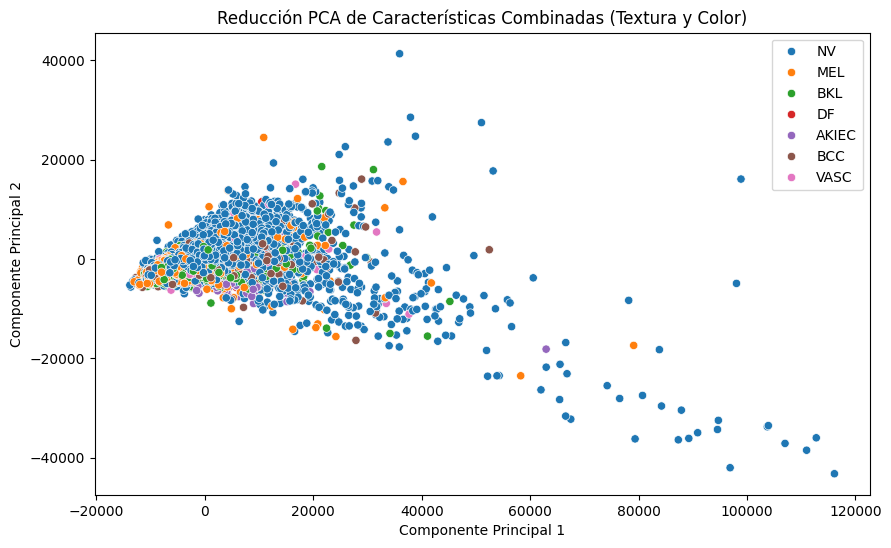

In [100]:
# Seleccionar columnas de características para PCA
feature_columns = [col for col in ground_truth.columns if col not in ['image', 'lesion_type']]
X = ground_truth[feature_columns]
y = ground_truth['lesion_type']

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.fillna(0))

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10')
plt.title("Reducción PCA de Características Combinadas (Textura y Color)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(loc="best")
plt.show()

### **Interpretación de la Reducción PCA de Características Combinadas (Textura y Color)**

**Descripción**
La gráfica muestra cómo el **PCA** (Análisis de Componentes Principales) reduce las características de textura (LBP, GLCM) y color (media, varianza, skewness, etc.) a dos componentes principales que capturan la mayor parte de la variabilidad del dataset. Cada punto representa una imagen, y los colores indican la clase de la lesión.

**Observaciones**
1. **Superposición entre clases:**
   - Las clases **NV**, **MEL**, y **BKL** están muy mezcladas, lo que refleja similitudes en textura y color.

2. **Clases más diferenciadas:**
   - Las clases **BCC** y **VASC** muestran una separación más clara, indicando patrones cromáticos y texturales únicos.

3. **Outliers:**
   - Algunos puntos están aislados (extremos del gráfico). Estos pueden representar lesiones con características atípicas.

**Implicaciones**
- **Mejoras posibles:** Agregar características adicionales (e.g., morfológicas) podría ayudar a separar mejor las clases superpuestas.
- **Relevancia de BCC y VASC:** Estas clases parecen más fáciles de identificar con las características actuales.

**Siguientes pasos**
1. Analizar los puntos aislados para entender su significado.
2. Probar otras técnicas como **t-SNE** o **UMAP** para una mejor visualización de las relaciones entre clases.
3. Entrenar modelos de clasificación para evaluar el impacto de las características combinadas en la precisión del diagnóstico.

### **Segmentación proporcionada por el dataset**

In [101]:
def apply_masks_to_images(image_list, image_folder, mask_folder):
    """
    Aplica máscaras de segmentación a una lista de imágenes específicas
    y muestra los resultados.

    Parameters:
        image_list (list): Lista de identificadores de imágenes (e.g., ["ISIC_0024306", "ISIC_0024307"]).
        image_folder (str): Ruta donde están almacenadas las imágenes originales.
        mask_folder (str): Ruta donde están almacenadas las máscaras de segmentación.
    """
    for image_id in image_list:
        # Construir las rutas para la imagen y la máscara
        image_path = os.path.join(image_folder, f"{image_id}.jpg")
        mask_path = os.path.join(mask_folder, f"{image_id}_segmentation.png")
        
        # Verificar si la imagen y la máscara existen
        if not os.path.exists(image_path):
            print(f"Imagen no encontrada: {image_path}")
            continue
        if not os.path.exists(mask_path):
            print(f"Máscara no encontrada: {mask_path}")
            continue
        
        # Aplicar la máscara
        original_image, binary_mask, masked_image = apply_mask(image_path, mask_path)
        
        # Visualizar los resultados
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Segmentación para {image_id}")
        
        plt.subplot(1, 3, 1)
        plt.title("Imagen Original")
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.title("Máscara de Segmentación")
        plt.imshow(binary_mask, cmap="gray")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.title("Imagen Segmentada")
        plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        
        plt.show()


# Lista de imágenes a procesar (puedes incluir cualquier conjunto de identificadores)
image_list = list(random_images.values())  # Usar las imágenes seleccionadas aleatoriamente

# Aplicar la función a la lista de imágenes
apply_masks_to_images(image_list, BASE_DIR/path_images, BASE_DIR/path_mask)

NameError: name 'apply_mask' is not defined

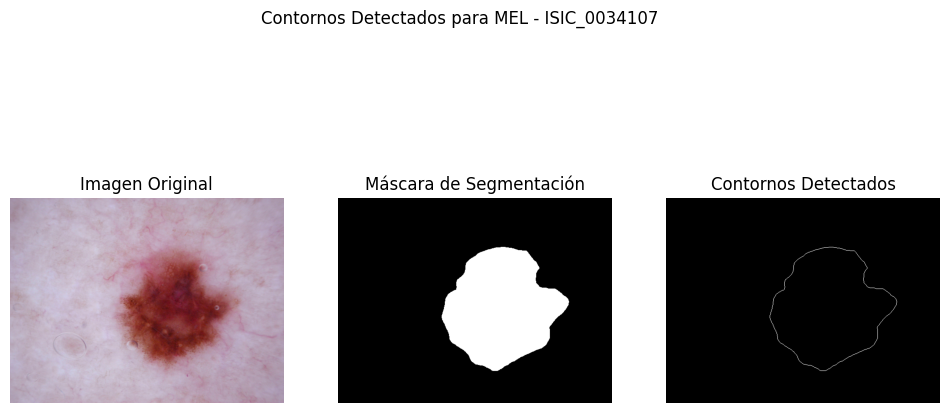

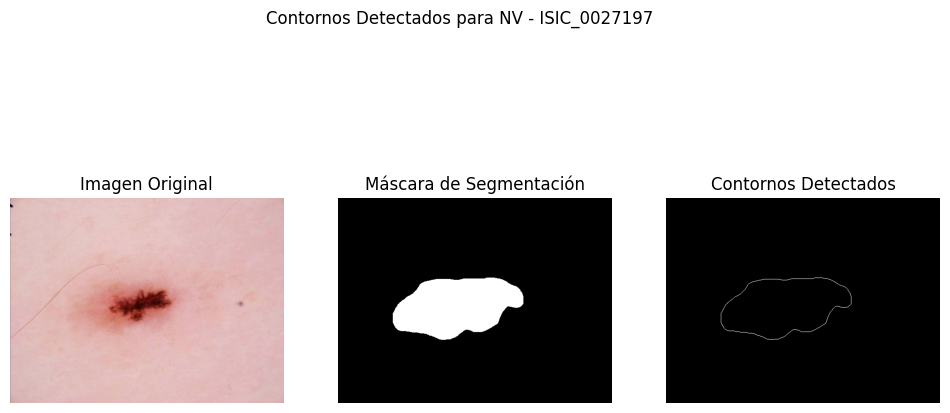

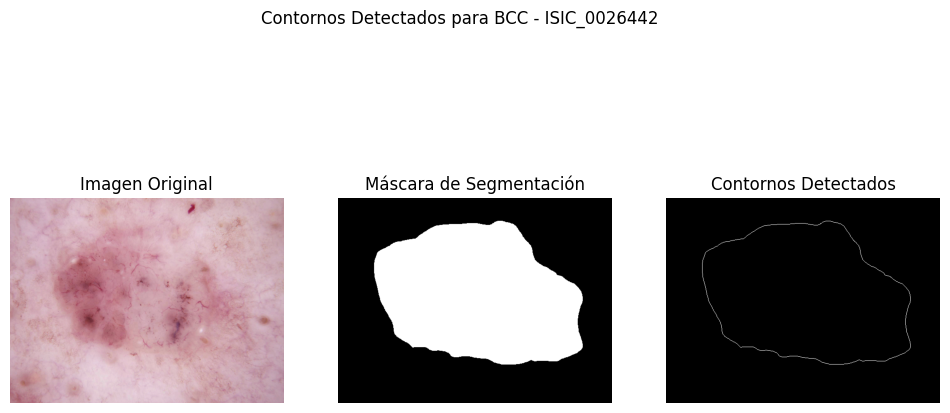

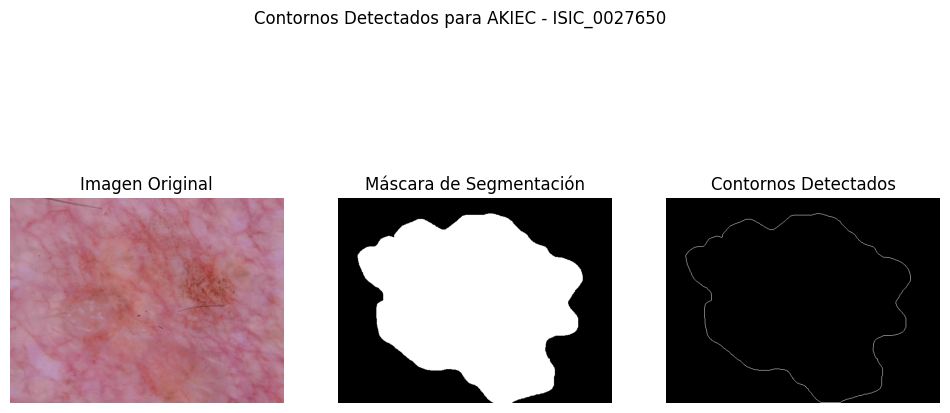

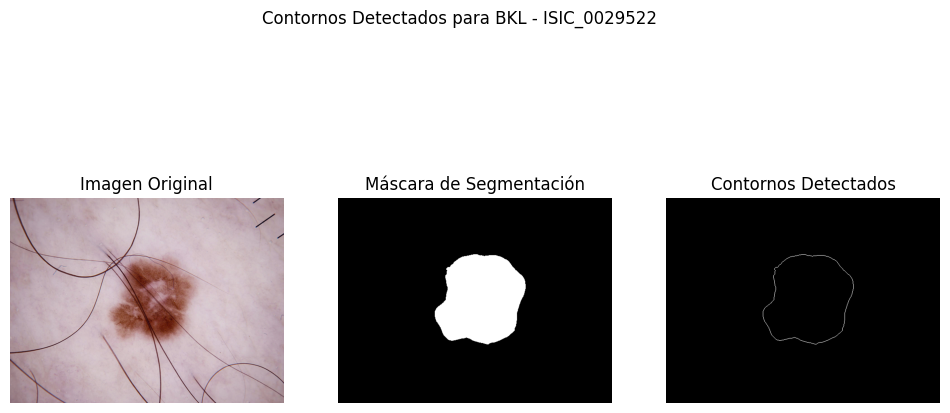

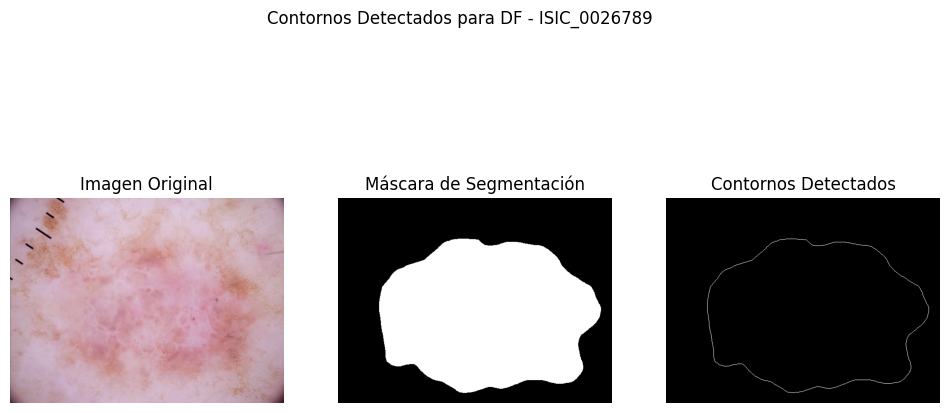

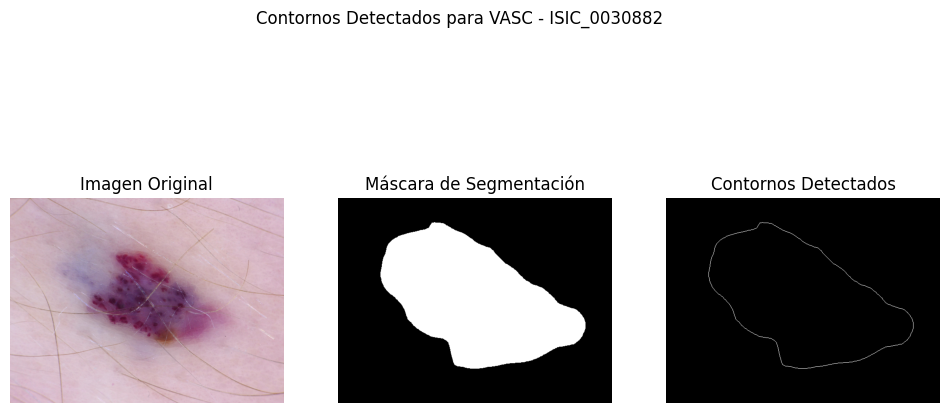

In [103]:
def visualize_random_image_contours(random_images, image_folder, mask_folder):
    """
    Visualiza los contornos de las imágenes seleccionadas aleatoriamente.

    Parameters:
        random_images (dict): Diccionario con pares de tipo de lesión e ID de imagen.
        image_folder (str): Carpeta donde están almacenadas las imágenes originales.
        mask_folder (str): Carpeta donde están almacenadas las máscaras de segmentación.
    """
    for lesion_type, image_id in random_images.items():
        # Construir las rutas de la imagen y la máscara
        image_path = os.path.join(image_folder, f"{image_id}.jpg")
        mask_path = os.path.join(mask_folder, f"{image_id}_segmentation.png")
        
        # Verificar si la imagen y la máscara existen
        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"Imagen o máscara no encontrada: {image_id}")
            continue
        
        # Leer la imagen original y la máscara
        original_image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Encontrar contornos en la máscara
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Dibujar los contornos sobre un fondo negro
        contours_image = np.zeros_like(mask)
        cv2.drawContours(contours_image, contours, -1, (255, 255, 255), thickness=1)
        
        # Visualizar la imagen original, la máscara y los contornos
        plt.figure(figsize=(12, 6))
        plt.suptitle(f"Contornos Detectados para {lesion_type} - {image_id}")
        
        # Imagen original
        plt.subplot(1, 3, 1)
        plt.title("Imagen Original")
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        
        # Máscara de segmentación
        plt.subplot(1, 3, 2)
        plt.title("Máscara de Segmentación")
        plt.imshow(mask, cmap="gray")
        plt.axis("off")
        
        # Imagen con contornos
        plt.subplot(1, 3, 3)
        plt.title("Contornos Detectados")
        plt.imshow(contours_image, cmap="gray")
        plt.axis("off")
        
        plt.show()


# Visualizar los contornos de las imágenes seleccionadas aleatoriamente
visualize_random_image_contours(
    random_images=random_images,
    image_folder=BASE_DIR/path_images,
    mask_folder=BASE_DIR/path_mask
)

#### Extracción las caracteristicas morfológicas usando la máscara

In [104]:
def extract_morphological_features_with_masks(image_list, mask_folder):
    """
    Extrae características morfológicas a partir de máscaras de segmentación.

    Parameters:
        image_list (list): Lista de identificadores de imágenes (e.g., ["ISIC_0024306", "ISIC_0024307"]).
        mask_folder (str): Ruta donde están almacenadas las máscaras de segmentación.

    Returns:
        pd.DataFrame: DataFrame con las características morfológicas extraídas.
    """
    features = []

    for image_id in image_list:
        # Construir la ruta de la máscara
        mask_path = os.path.join(mask_folder, f"{image_id}_segmentation.png")
        
        # Verificar si la máscara existe
        if not os.path.exists(mask_path):
            print(f"Máscara no encontrada: {mask_path}")
            continue
        
        # Leer la máscara binaria
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Encontrar contornos
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Verificar si se encontraron contornos
        if len(contours) == 0:
            print(f"No se encontraron contornos para {image_id}")
            continue
        
        # Tomar el contorno más grande (en caso de ruido)
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Calcular características morfológicas
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        x, y, w, h = cv2.boundingRect(largest_contour)
        aspect_ratio = float(w) / h
        compactness = (4 * 3.1416 * area) / (perimeter**2) if perimeter > 0 else 0
        extent = area / (w * h) if w > 0 and h > 0 else 0

        # Agregar las características al diccionario
        features.append({
            "image_id": image_id,
            "area": area,
            "perimeter": perimeter,
            "aspect_ratio": aspect_ratio,
            "compactness": compactness,
            "extent": extent
        })
    
    # Convertir las características a un DataFrame
    return pd.DataFrame(features)


In [105]:
# Extraer los identificadores de imágenes desde el DataFrame
image_ids = ground_truth['image'].tolist()

# Extraer características morfológicas usando los identificadores del DataFrame
morphological_features_df = extract_morphological_features_with_masks(image_ids, BASE_DIR/path_mask)

# Mostrar las primeras filas del DataFrame
morphological_features_df.head()

image_id      area    perimeter  aspect_ratio  compactness    extent
0  ISIC_0024306   91980.5  1329.266149      0.796117     0.654158  0.680651
1  ISIC_0024307  111947.5  1370.839744      0.957071     0.748604  0.745899
2  ISIC_0024308   99255.5  1482.437721      1.315217     0.567561  0.557265
3  ISIC_0024309   95638.5  1340.472210      1.089552     0.668849  0.782159
4  ISIC_0024310   64391.0  1425.567664      1.463235     0.398163  0.594803

In [106]:
# Combinar las características morfológicas con el DataFrame ground_truth
ground_truth = pd.merge(ground_truth, morphological_features_df, left_on='image', right_on='image_id', how='left')

# Eliminar la columna redundante 'image_id' después de la combinación
ground_truth = ground_truth.drop(columns=['image_id'])

# Mostrar las primeras filas del DataFrame actualizado
ground_truth.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  hsv_channel_0_mean  \
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0           78.139256   
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0          130.303393   
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0           81.811926   
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0          161.096467   
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0           74.559000   

   hsv_channel_0_std  ...  lbp_bin_25  glcm_contrast  glcm_correlation  \
0          87.370640  ...    0.493396      10.367475          0.994619   
1          77.785119  ...    0.510411      14.278045          0.979312   
2          87.347425  ...    0.492130      17.040497          0.996552   
3          49.154544  ...    0.481619       5.409920          0.994894   
4          84.311637  ...    0.426104      27.214016          0.986265   

   glcm_homogeneity  glcm_energy      area    perimeter  aspect_ratio  \
0          0.401977     0.051721   91980.5  1329.266149      0.796117   
1          0.389650     0.052217  111947.5  1370.839744      0.957071   
2          0.334614     0.037984   99255.5  1482.437721      1.315217   
3          0.422971     0.051959   95638.5  1340.472210      1.089552   
4          0.269218     0.031805   64391.0  1425.567664      1.463235   

   compactness    extent  
0     0.654158  0.680651  
1     0.748604  0.745899  
2     0.567561  0.557265  
3     0.668849  0.782159  
4     0.398163  0.594803  

[5 rows x 74 columns]

In [107]:
# almacenamos provicionalmente la data en un csv
ground_truth.to_csv('ground_truth_with_parameters.csv', index=False)

## Matriz de correlación

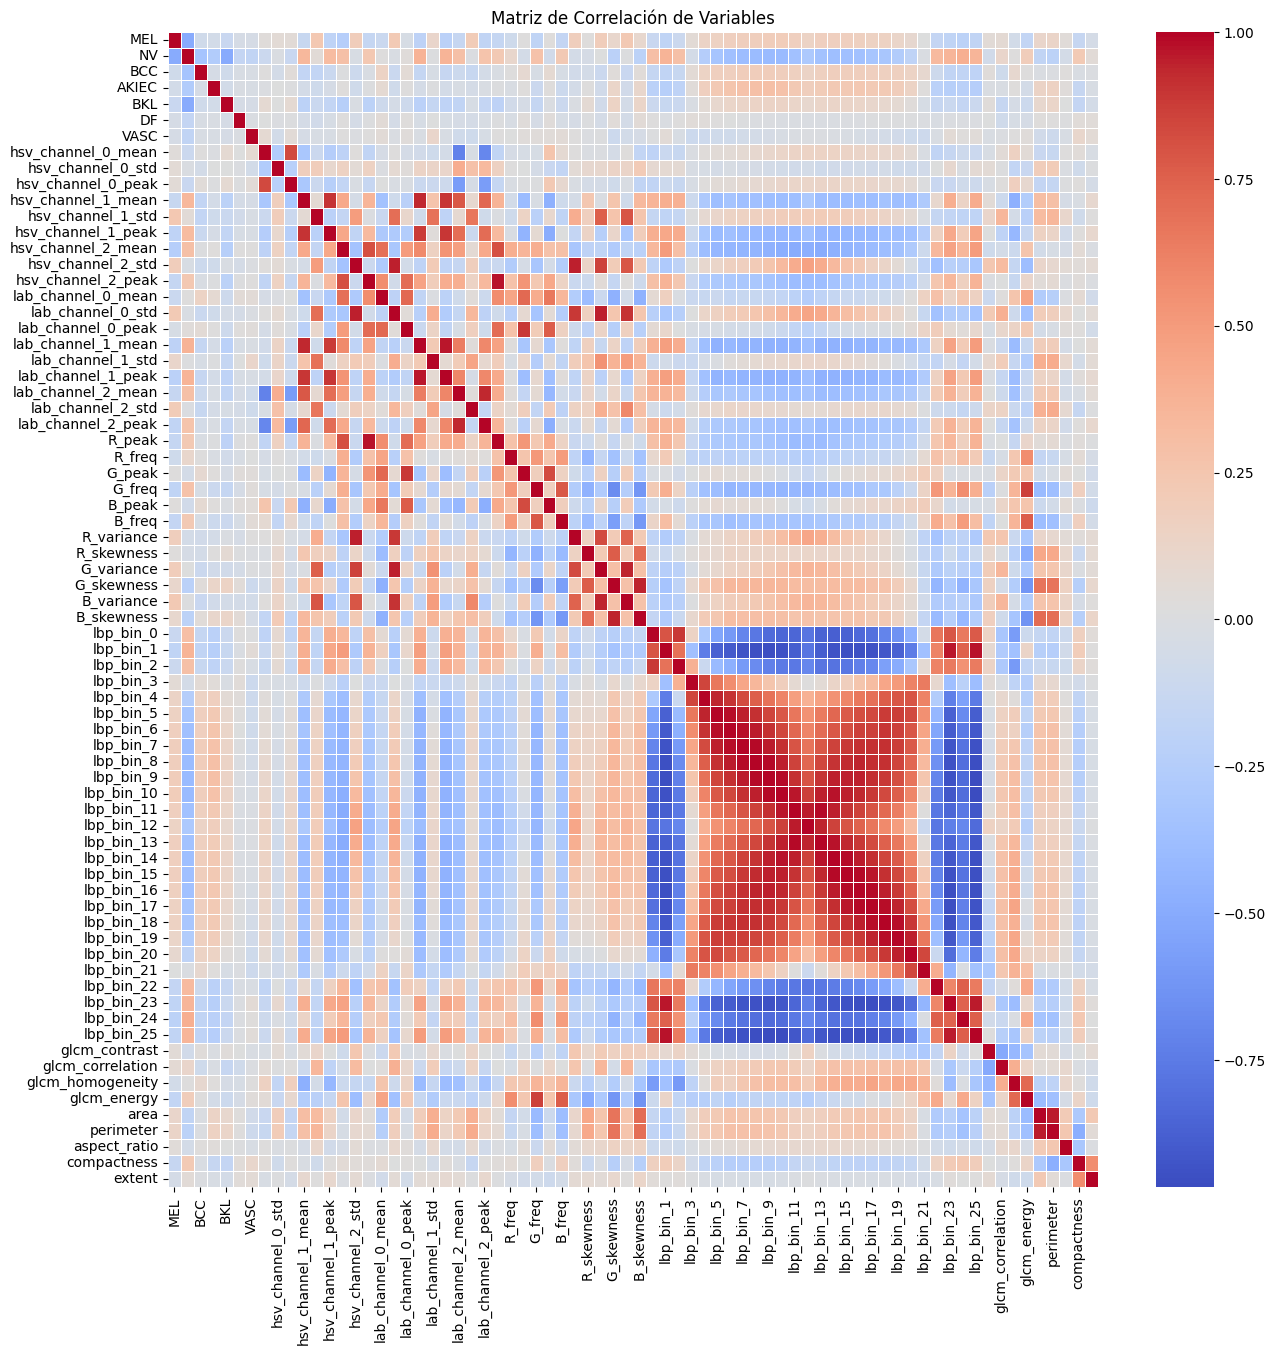

In [108]:
# Excluir columnas no numéricas
numeric_columns = ground_truth.select_dtypes(include=['float64', 'int64']).columns

# Generar la matriz de correlación
correlation_matrix = ground_truth[numeric_columns].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de Variables')
plt.show()

## Histogramas